<a href="https://colab.research.google.com/github/atreyat12/ICU_Explainability_Review/blob/main/XAI_ICU_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICU Admission Outcomes Analysis

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atreyat/ICU_Explainability_Review/blob/main/XAI_ICU_Study.ipynb)

This notebook explores predictors of ICU Length of Stay (LOS) and mortality using regression models and machine learning explainability tools like SHAP to answer the question: "Are there disparities in ICU outcomes by race, gender, or insurance type?" and "Do these potentially impact model predictions of healthcare outcomes?". Data is from [MIMIC-IV](https://physionet.org/content/mimiciv/3.1/hosp/#files-panel)

**Outcomes analyzed:**
- LOS (continuous)
- In Hospital Mortality (binary)


In [ ]:
pip install plotly

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ----------- ---------------------------- 2.9/9.9 MB 16.8 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.9 MB 23.8 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 22.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
import shap
import plotly.express as px
pd.set_option("mode.copy_on_write", True)


We explore four datasets, which need to be joined to fully understand the linkage between variables: admissions (people admitted to hospital), stays (stays in the hospital), patient (patient information), and icds, which represents diagnoses of patients.

In [ ]:
#reading in data
admissions = pd.read_csv("admissions.csv.gz")
stays = pd.read_csv("icustays.csv.gz")
patients = pd.read_csv("patients.csv.gz")


In [ ]:
icds = pd.read_csv("diagnoses_icd.csv.gz")

In [ ]:
icds.head()

subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9

Splitting data records into 9 and 10 since they are coded differently throughout dataset.

In [ ]:
icd9 = icds[icds['icd_version'] == 9]
icd10 = icds[icds['icd_version'] == 10]

In [ ]:
assert icd9['icd_version'].unique() == 9
assert icd10['icd_version'].unique() == 10

In [ ]:
admissions.groupby("subject_id")["hadm_id"].value_counts()

subject_id  hadm_id 
10000032    22595853    1
            22841357    1
            25742920    1
            29079034    1
10000068    25022803    1
                       ..
19999828    25744818    1
            29734428    1
19999840    21033226    1
            26071774    1
19999987    23865745    1
Name: count, Length: 546028, dtype: int64

In [ ]:
# looking at data and columns to figure out what to keep
admissions.sample(10)

subject_id   hadm_id            admittime            dischtime  \
421252    17719692  20923312  2182-05-26 23:51:00  2182-05-31 10:13:00   
16114     10308232  21297383  2156-04-13 00:00:00  2156-04-20 18:00:00   
17016     10322956  26290689  2159-10-12 20:18:00  2159-10-31 14:53:00   
215781    13975075  26446941  2150-04-27 00:15:00  2150-04-29 18:20:00   
156216    12881289  21629891  2177-07-01 10:30:00  2177-07-10 13:28:00   
144853    12672736  22634493  2152-05-22 02:03:00  2152-05-22 16:30:00   
338416    16205540  26911861  2173-10-15 05:20:00  2173-11-03 13:11:00   
13866     10267773  22887600  2120-03-02 03:27:00  2120-03-02 19:01:00   
151765    12795027  29763706  2135-11-21 20:48:00  2135-11-24 14:21:00   
396317    17259996  26651062  2153-05-20 00:57:00  2153-05-21 13:32:00   

       deathtime               admission_type admit_provider_id  \
421252       NaN                     EW EMER.            P5879D   
16114        NaN  SURGICAL SAME DAY ADMISSION            P81OE6   
17016        NaN                     EW EMER.            P24CB9   
215781       NaN            OBSERVATION ADMIT            P383RF   
156216       NaN                 DIRECT EMER.            P84J0Y   
144853       NaN            OBSERVATION ADMIT            P12VNM   
338416       NaN                     EW EMER.            P473FJ   
13866        NaN                     EW EMER.            P427NF   
151765       NaN               EU OBSERVATION            P392G4   
396317       NaN                     EW EMER.            P10JSY   

            admission_location        discharge_location insurance language  \
421252  TRANSFER FROM HOSPITAL          HOME HEALTH CARE  Medicare  English   
16114       PHYSICIAN REFERRAL                      HOME  Medicare  English   
17016           EMERGENCY ROOM          HOME HEALTH CARE   Private  English   
215781  TRANSFER FROM HOSPITAL                      HOME  Medicare  English   
156216      PHYSICIAN REFERRAL  SKILLED NURSING FACILITY  Medicaid  English   
144853          EMERGENCY ROOM                      HOME  Medicare  English   
338416   WALK-IN/SELF REFERRAL                      HOME     Other  English   
13866           EMERGENCY ROOM            AGAINST ADVICE  Medicaid  English   
151765      PHYSICIAN REFERRAL                       NaN   Private  English   
396317          EMERGENCY ROOM                      HOME   Private  English   

       marital_status                    race            edregtime  \
421252       DIVORCED  BLACK/AFRICAN AMERICAN  2182-05-26 18:33:00   
16114        DIVORCED                   WHITE                  NaN   
17016          SINGLE                   WHITE  2159-10-12 12:11:00   
215781        MARRIED                   WHITE  2150-04-26 18:26:00   
156216         SINGLE  BLACK/AFRICAN AMERICAN                  NaN   
144853        MARRIED                   WHITE  2152-05-21 18:54:00   
338416         SINGLE                   WHITE  2173-10-14 19:40:00   
13866          SINGLE  BLACK/AFRICAN AMERICAN  2120-03-01 20:56:00   
151765         SINGLE                   WHITE  2135-11-21 06:17:00   
396317       DIVORCED                   OTHER  2153-05-19 21:12:00   

                  edouttime  hospital_expire_flag  
421252  2182-05-27 01:11:00                     0  
16114                   NaN                     0  
17016   2159-10-12 21:49:00                     0  
215781  2150-04-27 02:57:00                     0  
156216                  NaN                     0  
144853  2152-05-22 04:06:00                     0  
338416  2173-10-15 08:27:00                     0  
13866   2120-03-02 04:52:00                     0  
151765  2135-11-24 14:54:00                     0  
396317  2153-05-20 02:13:00                     0

In [ ]:
stays.sample(10)

subject_id   hadm_id   stay_id  \
63740    16757040  23474165  37043594   
73236    17762094  27543995  34787715   
86864    19190026  20470600  30021727   
6485     10700130  23522288  30807981   
31617    13349420  28470899  35851200   
19709    12101596  27563538  34488264   
67061    17105565  25287548  37902544   
65829    16972827  25679174  34910855   
84160    18901279  22711048  32164070   
27669    12943357  22908022  39860038   

                                     first_careunit  \
63740                           Trauma SICU (TSICU)   
73236                           Trauma SICU (TSICU)   
86864                      Coronary Care Unit (CCU)   
6485             Medical Intensive Care Unit (MICU)   
31617                            Neuro Intermediate   
19709  Cardiac Vascular Intensive Care Unit (CVICU)   
67061            Medical Intensive Care Unit (MICU)   
65829                            Neuro Intermediate   
84160           Surgical Intensive Care Unit (SICU)   
27669                      Coronary Care Unit (CCU)   

                                      last_careunit               intime  \
63740                           Trauma SICU (TSICU)  2178-05-09 17:33:33   
73236                           Trauma SICU (TSICU)  2188-04-02 07:03:20   
86864                      Coronary Care Unit (CCU)  2139-05-23 16:18:00   
6485             Medical Intensive Care Unit (MICU)  2199-11-25 19:36:00   
31617                            Neuro Intermediate  2110-10-09 00:40:00   
19709  Cardiac Vascular Intensive Care Unit (CVICU)  2129-09-16 10:27:19   
67061            Medical Intensive Care Unit (MICU)  2121-10-04 12:56:07   
65829                            Neuro Intermediate  2136-01-24 00:06:00   
84160           Surgical Intensive Care Unit (SICU)  2128-10-04 15:00:56   
27669                      Coronary Care Unit (CCU)  2143-08-26 03:57:00   

                   outtime       los  
63740  2178-05-12 18:58:50  3.059225  
73236  2188-04-10 12:51:14  8.241597  
86864  2139-05-25 16:37:41  2.013669  
6485   2199-11-27 18:30:56  1.954815  
31617  2110-10-09 22:47:51  0.922118  
19709  2129-09-22 23:18:11  6.535324  
67061  2121-10-05 12:29:20  0.981400  
65829  2136-01-26 11:51:38  2.490023  
84160  2128-10-05 15:03:04  1.001481  
27669  2143-08-28 00:58:37  1.876123

In [ ]:
patients.shape

(364627, 6)

In [ ]:
patients.sample(10)

subject_id gender  anchor_age  anchor_year anchor_year_group  dod
276069    17581511      F          69         2182       2011 - 2013  NaN
260889    17168243      F          65         2178       2008 - 2010  NaN
226054    16214737      F          35         2132       2014 - 2016  NaN
306904    18426073      M          32         2170       2020 - 2022  NaN
299692    18226587      M          54         2164       2014 - 2016  NaN
324638    18908955      F          23         2159       2011 - 2013  NaN
258555    17102279      F          25         2143       2014 - 2016  NaN
28755     10793883      F          39         2136       2014 - 2016  NaN
260043    17143165      F          44         2175       2020 - 2022  NaN
224535    16173643      F          63         2186       2020 - 2022  NaN

### Cleaning and merging data  
Are there disparities in ICU outcomes by race, gender, or insurance type?  

- Need to:  
    - subset icuvisits to just subject_id, hadm_id, and maybe stay_id (think about checking for multiple stays or duplicates)
    - join to patients on subject_id
    - subset admissions for subject_id, race, insurance, hadm_id
    - Join with icuvisits on subject_id, hadm_id

In [ ]:
admissions["insurance"].value_counts()

insurance
Medicare     244576
Private      173399
Medicaid     104229
Other         14006
No charge       463
Name: count, dtype: int64

In [ ]:
(14006+463)/admissions.shape[0]

0.026498641095328446

In [ ]:
#subsetting admissions for columns of interest
adm_info = admissions[['subject_id', 'hadm_id', 'race', 'insurance', 'admittime', 'dischtime', 'deathtime']]

In [ ]:
# dropping those with null insurance and other types
adm_info.dropna(subset=['insurance'], inplace=True)
adm_info = adm_info[adm_info['insurance'] != 'Other']
adm_info = adm_info[adm_info['insurance'] != 'No charge']

adm_info.insurance.unique()

array(['Medicaid', 'Medicare', 'Private'], dtype=object)

In [ ]:
#look at race, consider recoding to: White, Other, Unknown, Hispanic/Latino, Asian, American Indian/Alaskan, Native Hawaiian / Pacific Islander, Mulitple Race/Ethnicity
adm_info.race.unique()

array(['WHITE', 'OTHER', 'BLACK/AFRICAN AMERICAN', 'UNKNOWN',
       'WHITE - RUSSIAN', 'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'PORTUGUESE',
       'WHITE - OTHER EUROPEAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN', 'ASIAN - CHINESE', 'HISPANIC/LATINO - DOMINICAN',
       'HISPANIC/LATINO - SALVADORAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - SOUTH EAST ASIAN',
       'WHITE - BRAZILIAN', 'SOUTH AMERICAN', 'HISPANIC OR LATINO',
       'ASIAN - KOREAN', 'BLACK/CARIBBEAN ISLAND',
       'HISPANIC/LATINO - MEXICAN', 'PATIENT DECLINED TO ANSWER',
       'HISPANIC/LATINO - CUBAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'MULTIPLE RACE/ETHNICITY', 'WHITE - EASTERN EUROPEAN',
       'HISPANIC/LATINO - HONDURAN', 'ASIAN - ASIAN INDIAN',
       'HISPANIC/LATINO - COLUMBIAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN'], dtype=object)

Coding the race to simplify categories

In [ ]:
adm_info.loc[(adm_info['race'].str.contains('HISPANIC')) | (adm_info['race'].str.contains('SOUTH AMERICAN')), 'race'] = 'HISPANIC/LATINO'
adm_info.loc[(adm_info['race'].str.contains('WHITE')) | (adm_info['race'].str.contains('PORTUGUESE')), 'race'] = 'WHITE'
adm_info.loc[adm_info['race'].str.contains('ASIAN'), 'race'] = 'ASIAN'
adm_info.loc[adm_info['race'].str.contains('BLACK'), 'race'] = 'BLACK'
adm_info.loc[(adm_info['race'].str.contains('UNABLE')) | (adm_info['race'].str.contains('DECLINED')), 'race'] = 'UNKNOWN'
adm_info.loc[adm_info['race'].str.contains('NATIVE HAWAIIAN'), 'race'] = 'NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER'

In [ ]:
adm_info.race.value_counts()

race
WHITE                                     350020
BLACK                                      84632
HISPANIC/LATINO                            30495
ASIAN                                      18757
OTHER                                      18439
UNKNOWN                                    17695
AMERICAN INDIAN/ALASKA NATIVE               1165
MULTIPLE RACE/ETHNICITY                      551
NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER       450
Name: count, dtype: int64

This is where we merge admission and icu stay data to better examine data.

In [ ]:
#merge hopsital admission and icu stays
icu_adms = adm_info.merge(stays, how='inner', on = ['subject_id', 'hadm_id'], indicator=True, validate='one_to_many')

In [ ]:
icu_adms._merge.value_counts() # ensure merged correct

_merge
both          90599
left_only         0
right_only        0
Name: count, dtype: int64

In [ ]:
#dropping the _merge column after checking merge worked
icu_adms.drop('_merge', axis = 1, inplace = True)
icu_adms.columns

Index(['subject_id', 'hadm_id', 'race', 'insurance', 'admittime', 'dischtime',
       'deathtime', 'stay_id', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los'],
      dtype='object')

In [ ]:
#merge with patients
icu_adms = icu_adms.merge(patients, how='inner', on = 'subject_id', indicator = True, validate = 'many_to_one')

In [ ]:
icu_adms._merge.value_counts() #ensure merged correct

_merge
both          90599
left_only         0
right_only        0
Name: count, dtype: int64

In [ ]:
#dropping the _merge column after checking merge worked

icu_adms.drop('_merge', axis = 1, inplace = True)
icu_adms.columns

Index(['subject_id', 'hadm_id', 'race', 'insurance', 'admittime', 'dischtime',
       'deathtime', 'stay_id', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod'],
      dtype='object')

**merging with ICD codes and computing comorbidity scores because there are multiple diagnoses per hospital visit, leading to a separate row per visit, so better to combine the diagnoses together**  


In [ ]:
icu_counts = icu_adms.groupby('hadm_id')['stay_id'].nunique()

# Filter to only hadm_ids with more than one ICU stay
multi_icu_hadm = icu_counts[icu_counts > 1]

In [ ]:
icu_adms.shape

(90599, 18)

In [ ]:
multi_icu_hadm.shape

(7419,)

< 8% of ICU stays were repeats within the same hadm_id so each ICU stay was treated as a separate observation, because the icd codes are per hospital admission and patient, but there can be multiple ICU visits per hadm_id so it might not reflect the icd of the ICU visit, however, since so few have multiple ICU visits per hadm_id, we will treat them as if they are separate.

Basically copied comorbidity function from the package but changed it so the id field could be a list because needed to keep hadm_id AND subject_id for future merge (used Chat GPT help)

In [ ]:
pip install comorbidipy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
import pandas as pd

# Monkey-patch the missing import
if not hasattr(pd.core.common, 'SettingWithCopyWarning'):
    # In pandas 2.x, it was moved
    try:
        from pandas.errors import SettingWithCopyWarning
        pd.core.common.SettingWithCopyWarning = SettingWithCopyWarning
    except ImportError:
        # If that doesn't work, create a dummy warning class
        class SettingWithCopyWarning(Warning):
            pass
        pd.core.common.SettingWithCopyWarning = SettingWithCopyWarning

# NOW import comorbidipy
from comorbidipy import comorbidity
from comorbidipy.mapping import mapping
from comorbidipy.colnames import get_colnames
from comorbidipy.calculator import _calculate_weighted_score
from comorbidipy.calculator import _age_adjust

In [ ]:
from comorbidipy import comorbidity
import math
from comorbidipy.mapping import mapping
from comorbidipy.colnames import get_colnames
from comorbidipy.calculator import _calculate_weighted_score
from comorbidipy.calculator import _age_adjust

def modified_comorbidity(
    df: pd.DataFrame,
    id,  # Can now be a string or list of strings
    code: str = "code",
    age: str = "age",
    score: str = "charlson",
    icd: str = "icd10",
    variant: str = "quan",
    weighting: str = "quan",
    assign0: bool = True,
) -> pd.DataFrame:
    if isinstance(id, list):
        df["__id__"] = df[id].astype(str).agg("_".join, axis=1)
        id_col = "__id__"
    else:
        id_col = id

    if id_col not in df.columns or code not in df.columns:
        raise KeyError(f"Missing column(s). Ensure column(s) {id_col}, {code} are present.")

    df = df.dropna(subset=[id_col, code])

    if age:
        if age not in df.columns:
            raise KeyError(f"Column age was assigned {age} but not found")
        dfid = df[[id_col, age]].drop_duplicates(subset=[id_col])
    else:
        dfid = df[[id_col]].drop_duplicates()

    score_icd_variant = f"{score}_{icd}_{variant}"
    if score_icd_variant not in mapping.keys():
        raise KeyError(
            f"Combination of score, icd and variant not found in mappings. Allowed: {list(mapping)}"
        )

    reverse_mapping = {
        i: k
        for i in df[code].unique()
        for k, v in mapping[score_icd_variant].items()
        if isinstance(i, str) and i.startswith(tuple(v))
    }

    df[code] = df[code].where(df[code].isin(reverse_mapping), other=None)
    df = df.dropna(subset=[code]).drop_duplicates(subset=[id_col, code])
    df[code] = df[code].replace(reverse_mapping)
    df = df.drop_duplicates(subset=[id_col, code])
    df["tmp"] = 1
    dfp = df.pivot(index=id_col, columns=code, values="tmp").fillna(0)

    colnames = get_colnames(score)
    for c in colnames:
        if c not in dfp.columns:
            dfp[c] = 0

    dfp = _calculate_weighted_score(dfp, score_icd_variant, assign0, weighting)

    if age:
        dfp = dfid.merge(dfp, on=id_col, how="left").fillna(0)
        dfp = _age_adjust(dfp, age)
        if score == "charlson" and weighting == "charlson":
            dfp["survival_10yr"] = dfp["age_adj_comorbidity_score"].apply(
                lambda x: 0.983 ** math.exp(0.9 * x)
            )
    else:
        dfp = dfid.merge(dfp, on=id_col, how="left").fillna(0)

    dfp.attrs = {
        "score": score,
        "icd": icd,
        "variant": variant,
        "weighting": weighting,
        "assign0": assign0,
    }

    return dfp


# Compute separately
res9 = modified_comorbidity(icd9, id=['subject_id', 'hadm_id'], code='icd_code', score='charlson', icd='icd9', assign0=True, age=None)
res10 = modified_comorbidity(icd10, id=['subject_id', 'hadm_id'], code='icd_code', score='charlson', icd='icd10', assign0=True, age=None)


# Combine
combined = pd.concat([res9, res10], ignore_index=True)


In [ ]:
combined

__id__  aids  ami  canc  cevd  chf  copd  dementia  diab  \
0       10000032_22595853   0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0   
1       10000032_22841357   0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0   
2       10000032_25742920   0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0   
3       10000032_29079034   0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0   
4       10000068_25022803   0.0  0.0   0.0   0.0  0.0   0.0       0.0   0.0   
...                   ...   ...  ...   ...   ...  ...   ...       ...   ...   
545502  19999784_29355057   0.0  0.0   1.0   0.0  0.0   0.0       0.0   0.0   
545503  19999784_29889147   0.0  0.0   1.0   0.0  0.0   0.0       0.0   0.0   
545504  19999784_29956342   0.0  0.0   1.0   0.0  0.0   0.0       0.0   0.0   
545505  19999828_25744818   0.0  0.0   0.0   0.0  0.0   1.0       0.0   1.0   
545506  19999828_29734428   0.0  0.0   0.0   0.0  0.0   1.0       0.0   1.0   

        diabwc   hp  metacanc  mld  msld  pud  pvd  rend  rheumd  \
0          0.0  0.0       0.0  1.0   1.0  0.0  0.0   0.0     0.0   
1          0.0  0.0       0.0  1.0   0.0  0.0  0.0   0.0     0.0   
2          0.0  0.0       0.0  1.0   0.0  0.0  0.0   0.0     0.0   
3          0.0  0.0       0.0  1.0   0.0  0.0  0.0   0.0     0.0   
4          0.0  0.0       0.0  0.0   0.0  0.0  0.0   0.0     0.0   
...        ...  ...       ...  ...   ...  ...  ...   ...     ...   
545502     0.0  1.0       0.0  0.0   0.0  0.0  0.0   0.0     0.0   
545503     0.0  0.0       0.0  0.0   0.0  0.0  0.0   0.0     0.0   
545504     0.0  0.0       0.0  0.0   0.0  0.0  0.0   0.0     0.0   
545505     0.0  0.0       0.0  0.0   0.0  0.0  0.0   0.0     0.0   
545506     0.0  0.0       0.0  0.0   0.0  0.0  0.0   0.0     0.0   

        comorbidity_score  
0                     5.0  
1                     3.0  
2                     3.0  
3                     3.0  
4                     0.0  
...                   ...  
545502                4.0  
545503                2.0  
545504                2.0  
545505                1.0  
545506                1.0  

[545507 rows x 19 columns]

In [ ]:
combined[["subject_id", "hadm_id"]] = combined["__id__"].str.split("_", expand=True)

# Convert to correct int type
combined["subject_id"] = combined["subject_id"].astype(int)
combined["hadm_id"] = combined["hadm_id"].astype(int)
combined.drop(columns=["__id__"], inplace=True)
combined


aids  ami  canc  cevd  chf  copd  dementia  diab  diabwc   hp  \
0        0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0     0.0  0.0   
1        0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0     0.0  0.0   
2        0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0     0.0  0.0   
3        0.0  0.0   0.0   0.0  0.0   1.0       0.0   0.0     0.0  0.0   
4        0.0  0.0   0.0   0.0  0.0   0.0       0.0   0.0     0.0  0.0   
...      ...  ...   ...   ...  ...   ...       ...   ...     ...  ...   
545502   0.0  0.0   1.0   0.0  0.0   0.0       0.0   0.0     0.0  1.0   
545503   0.0  0.0   1.0   0.0  0.0   0.0       0.0   0.0     0.0  0.0   
545504   0.0  0.0   1.0   0.0  0.0   0.0       0.0   0.0     0.0  0.0   
545505   0.0  0.0   0.0   0.0  0.0   1.0       0.0   1.0     0.0  0.0   
545506   0.0  0.0   0.0   0.0  0.0   1.0       0.0   1.0     0.0  0.0   

        metacanc  mld  msld  pud  pvd  rend  rheumd  comorbidity_score  \
0            0.0  1.0   1.0  0.0  0.0   0.0     0.0                5.0   
1            0.0  1.0   0.0  0.0  0.0   0.0     0.0                3.0   
2            0.0  1.0   0.0  0.0  0.0   0.0     0.0                3.0   
3            0.0  1.0   0.0  0.0  0.0   0.0     0.0                3.0   
4            0.0  0.0   0.0  0.0  0.0   0.0     0.0                0.0   
...          ...  ...   ...  ...  ...   ...     ...                ...   
545502       0.0  0.0   0.0  0.0  0.0   0.0     0.0                4.0   
545503       0.0  0.0   0.0  0.0  0.0   0.0     0.0                2.0   
545504       0.0  0.0   0.0  0.0  0.0   0.0     0.0                2.0   
545505       0.0  0.0   0.0  0.0  0.0   0.0     0.0                1.0   
545506       0.0  0.0   0.0  0.0  0.0   0.0     0.0                1.0   

        subject_id   hadm_id  
0         10000032  22595853  
1         10000032  22841357  
2         10000032  25742920  
3         10000032  29079034  
4         10000068  25022803  
...            ...       ...  
545502    19999784  29355057  
545503    19999784  29889147  
545504    19999784  29956342  
545505    19999828  25744818  
545506    19999828  29734428  

[545507 rows x 20 columns]

In [ ]:
combined = combined.drop_duplicates(subset=['subject_id', 'hadm_id'])
# drop duplicates

In [ ]:
icu_adms = icu_adms.merge(combined, how='inner', on= ['subject_id', 'hadm_id'], indicator = True, validate='m:m')
#merge with main dataset

In [ ]:
icu_adms._merge.value_counts()

_merge
both          90575
left_only         0
right_only        0
Name: count, dtype: int64

In [ ]:
icu_adms.drop('_merge', axis = 1, inplace = True)
icu_adms.columns

Index(['subject_id', 'hadm_id', 'race', 'insurance', 'admittime', 'dischtime',
       'deathtime', 'stay_id', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'aids', 'ami', 'canc', 'cevd', 'chf',
       'copd', 'dementia', 'diab', 'diabwc', 'hp', 'metacanc', 'mld', 'msld',
       'pud', 'pvd', 'rend', 'rheumd', 'comorbidity_score'],
      dtype='object')

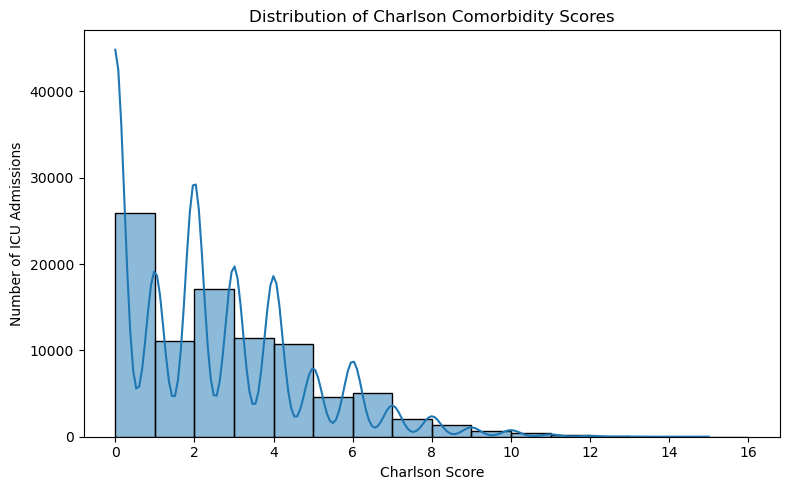

In [ ]:
#plot distribution
plt.figure(figsize=(8,5))
sns.histplot(icu_adms['comorbidity_score'], bins=range(0, int(icu_adms['comorbidity_score'].max())+2), kde=True)
plt.title('Distribution of Charlson Comorbidity Scores')
plt.xlabel('Charlson Score')
plt.ylabel('Number of ICU Admissions')
plt.tight_layout()
plt.show()


**Note on anchor year and age from MIMIC**   

The `anchor_year` column is a deidentified year occurring sometime between 2100 - 2200, and the `anchor_year_group` column is one of the following values: "2008 - 2010", "2011 - 2013", "2014 - 2016", "2017 - 2019", and "2020 - 2022". These pieces of information allow researchers to infer the approximate year a patient received care. For example, if a patient's `anchor_year` is 2158, and their `anchor_year_group` is 2011 - 2013, then any hospitalizations for the patient occurring in the year 2158 actually occurred sometime between 2011 - 2013. In order to minimize accidental release of information, only a single `anchor_year` is provided per `subject_id`. Consequently, individual stays must be aligned to the anchor year using the respective date (e.g. admittime). Finally, the `anchor_age` provides the patient age in the given `anchor_year`. If the patient was over 89 in the `anchor_year`, this `anchor_age` has been set to 91 (i.e. all patients over 89 have been grouped together into a single group with value 91, regardless of what their real age was).

In [ ]:
#create age column based on anchor year and anchor age
icu_adms['age'] = icu_adms['anchor_age'] + (icu_adms['anchor_year'] - pd.to_datetime(icu_adms['admittime']).dt.year)


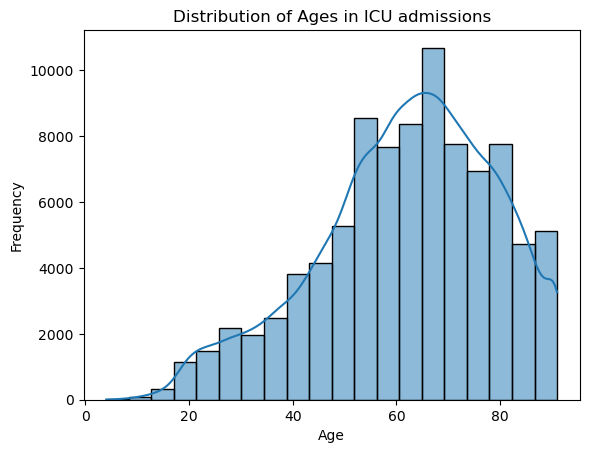

In [ ]:
# plot age distributions to see if it worked
sns.histplot(icu_adms['age'], kde=True, bins=20)
plt.title('Distribution of Ages in ICU admissions')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#checking merges
# Should be unique for ICU-level rows
assert icu_adms[["stay_id"]].duplicated().sum() == 0


In [ ]:
#Creating column for in icu mortality flag for outcome variable
icu_adms["outtime"] = pd.to_datetime(icu_adms["outtime"])
icu_adms["dod"] = pd.to_datetime(icu_adms["dod"])

# Create in-hospital mortality flag
icu_adms["in_icu_mortality"] = (
    icu_adms["dod"].notnull() &
    (icu_adms["dod"] <= icu_adms["outtime"])
).astype(int)

In [ ]:
icu_adms.in_icu_mortality.value_counts()

in_icu_mortality
0    83305
1     7270
Name: count, dtype: int64

In [ ]:
# create age bins
# Define age buckets in decades
icu_adms['age_group'] = pd.cut(
    icu_adms['age'],
    bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 120],
    labels=['0-9','10-19','20-29','30-39','40-49',
            '50-59','60-69','70-79','80-89','90+'],
    right=True,
    include_lowest=True
)
icu_adms['age_group'].value_counts()

age_group
60-69    21102
70-79    17985
50-59    17057
80-89    11599
40-49     9743
30-39     5581
20-29     3856
90+       2730
10-19      896
0-9         26
Name: count, dtype: int64

### Exploratory Visualizations

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\2710884308.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


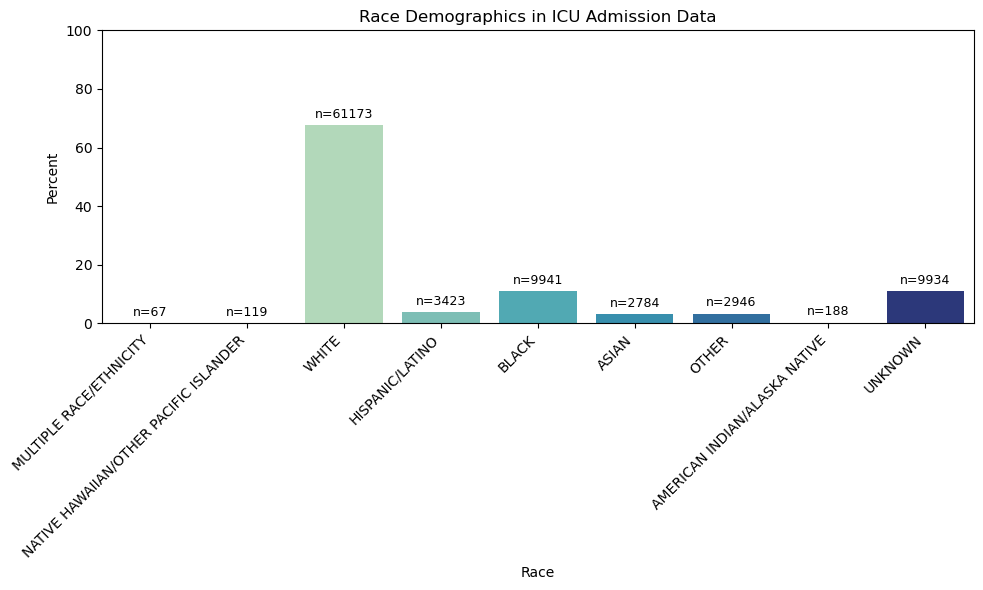

In [ ]:
race_order = [
    'MULTIPLE RACE/ETHNICITY', 'NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER',
    'WHITE', 'HISPANIC/LATINO', 'BLACK', 'ASIAN', 'OTHER',
    'AMERICAN INDIAN/ALASKA NATIVE', 'UNKNOWN'
]

# Calculate counts and percent
race_counts = icu_adms['race'].value_counts().reindex(race_order)
race_percents = (race_counts / race_counts.sum()) * 100

# Create DataFrame for plotting
race_df = pd.DataFrame({
    'Race': race_order,
    'Percent': race_percents.values,
    'Count': race_counts.values
})

# Custom palette matching LOS chart
colors = sns.color_palette("YlGnBu", n_colors=len(race_order))
color_dict = dict(zip(race_order, colors))

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=race_df,
    x='Race',
    y='Percent',
    order=race_order,
    palette=[color_dict[r] for r in race_order]
)

# Annotate counts on top of bars
for i, row in race_df.iterrows():
    ax.text(i, row['Percent'] + 1.5, f"n={int(row['Count'])}", ha='center', va='bottom', fontsize=9)

# Aesthetics
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Race")
plt.ylabel("Percent")
plt.title("Race Demographics in ICU Admission Data")
plt.tight_layout()
plt.show()

In [ ]:
race_counts

race
MULTIPLE RACE/ETHNICITY                      67
NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER      119
WHITE                                     61173
HISPANIC/LATINO                            3423
BLACK                                      9941
ASIAN                                      2784
OTHER                                      2946
AMERICAN INDIAN/ALASKA NATIVE               188
UNKNOWN                                    9934
Name: count, dtype: int64

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\299201815.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values * 100, palette=[gender_colors[gen] for gen in gender_counts.index])


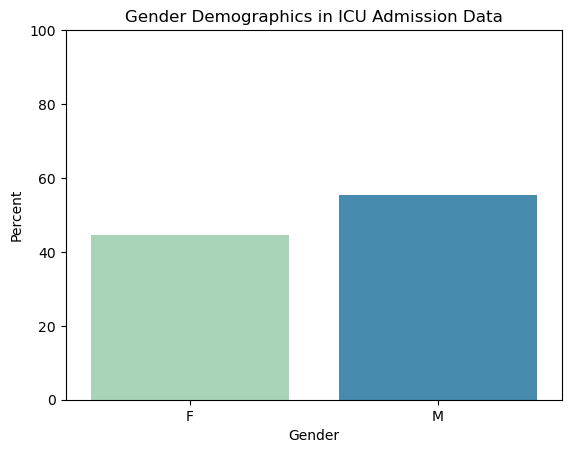

In [ ]:
gender_colors = {'F': '#a1dab4', 'M': '#3690c0'}  # keep with same color theme

# Plot gender demographics as percent with custom colors
gender_counts = icu_adms['gender'].value_counts(normalize=True).sort_index()
sns.barplot(x=gender_counts.index, y=gender_counts.values * 100, palette=[gender_colors[gen] for gen in gender_counts.index])

plt.ylim(0, 100)
plt.title("Gender Demographics in ICU Admission Data")
plt.xlabel("Gender")
plt.ylabel("Percent")
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\1735286293.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = icu_adms.pivot_table(index='weekday', columns='hour', values='stay_id', aggfunc='count')


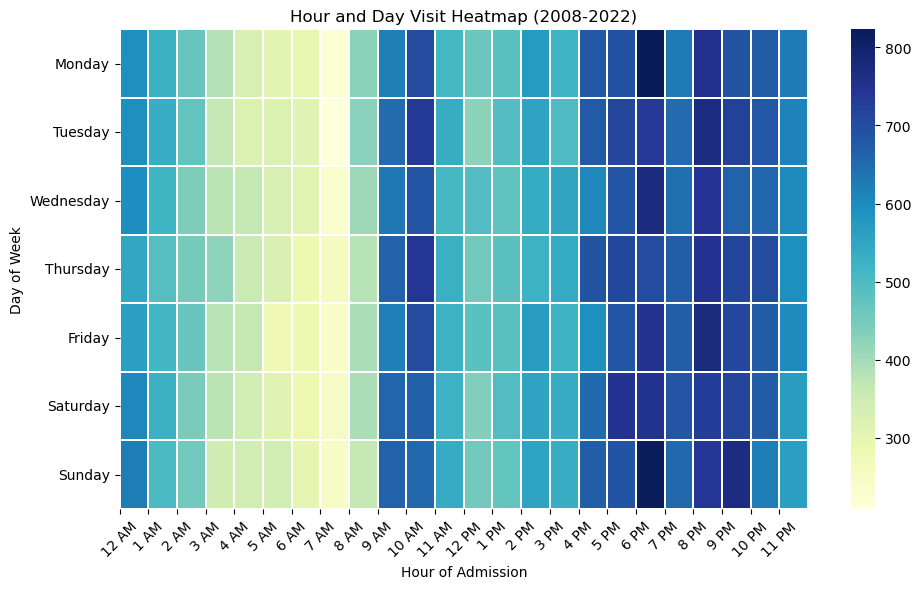

In [ ]:


# Extract hour and weekday
icu_adms['hour'] = pd.to_datetime(icu_adms['intime']).dt.hour
icu_adms['weekday'] = pd.to_datetime(icu_adms['intime']).dt.day_name()

# Ensure weekday order: Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
icu_adms['weekday'] = pd.Categorical(icu_adms['weekday'], categories=weekday_order, ordered=True)

# Create pivot table
pivot = icu_adms.pivot_table(index='weekday', columns='hour', values='stay_id', aggfunc='count')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.2)

# X-axis as 12 AM to 11 PM
hour_labels = [f"{h % 12 or 12} {'AM' if h < 12 else 'PM'}" for h in range(24)]
plt.xticks(ticks=range(24), labels=hour_labels, rotation=45)

# Add title with date range
start_year = icu_adms['anchor_year_group'].min()
end_year = icu_adms['anchor_year_group'].max()
plt.title(f"Hour and Day Visit Heatmap (2008-2022)")

plt.xlabel("Hour of Admission")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()



C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\1391053123.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = icu_adms.pivot_table(index='weekday', columns='month', values='stay_id', aggfunc='count')


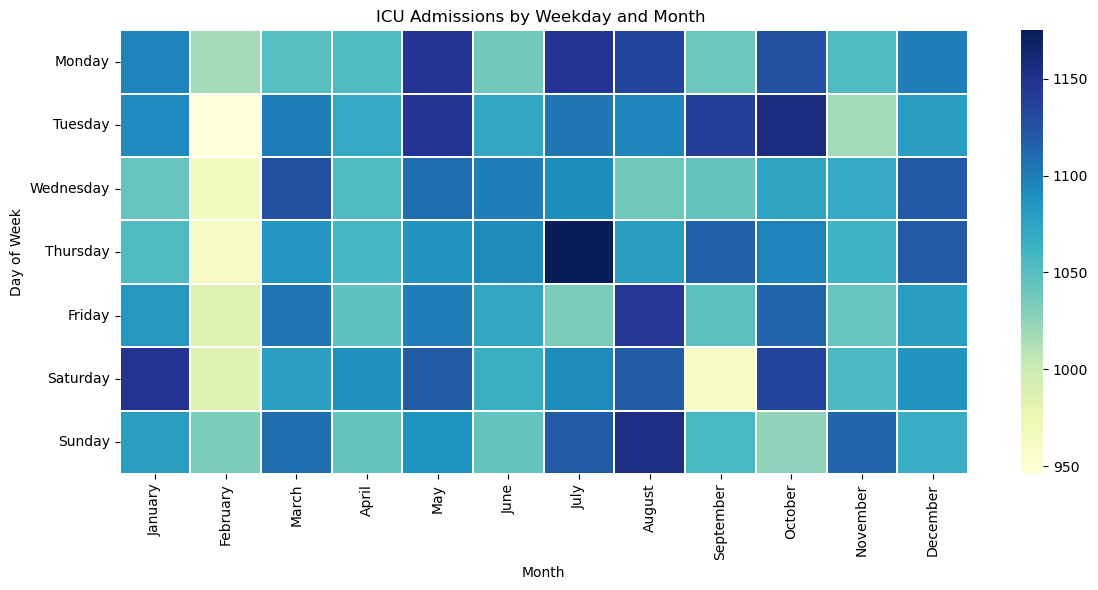

In [ ]:
# Convert 'intime' to datetime and extract weekday + month
icu_adms['intime'] = pd.to_datetime(icu_adms['intime'])
icu_adms['weekday'] = icu_adms['intime'].dt.day_name()
icu_adms['month'] = icu_adms['intime'].dt.month_name()

# Set order for weekday and month
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

icu_adms['weekday'] = pd.Categorical(icu_adms['weekday'], categories=weekday_order, ordered=True)
icu_adms['month'] = pd.Categorical(icu_adms['month'], categories=month_order, ordered=True)

# Pivot table: count of visits by weekday and month
pivot = icu_adms.pivot_table(index='weekday', columns='month', values='stay_id', aggfunc='count')

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.3)


plt.title(f"ICU Admissions by Weekday and Month ")
plt.xlabel("Month")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

In [ ]:
# Count of admissions by first care unit
df = icu_adms.copy()
careunit_counts = df['first_careunit'].value_counts().reset_index()
careunit_counts.columns = ['Care Unit', 'Patient Count']

# Sort for cleaner visuals
careunit_counts = careunit_counts.sort_values('Patient Count', ascending=False)

# Plot
fig = px.bar(
    careunit_counts,
    x='Patient Count',
    y='Care Unit',
    orientation='h',
    title='ICU Admissions by First Care Unit',
    color='Patient Count',
    color_continuous_scale='Blues',
    text='Patient Count'
)

fig.update_layout(
    xaxis_title='Number of Admissions',
    yaxis_title='First ICU Care Unit',
    yaxis=dict(categoryorder='total ascending'),
    title_font=dict(size=20),
    plot_bgcolor='white'
)
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
# Filter for patients who died
df_deceased = df[df['dod'].notnull()]

careunit_counts = df_deceased['first_careunit'].value_counts().reset_index()
careunit_counts.columns = ['Care Unit', 'Patient Count']

# Sort for cleaner visuals
careunit_counts = careunit_counts.sort_values('Patient Count', ascending=False)

# Plot
fig = px.bar(
    careunit_counts,
    x='Patient Count',
    y='Care Unit',
    orientation='h',
    title='ICU Admissions by First Care Unit',
    color='Patient Count',
    color_continuous_scale='Blues',
    text='Patient Count'
)

fig.update_layout(
    xaxis_title='Number of Admissions',
    yaxis_title='First ICU Care Unit',
    yaxis=dict(categoryorder='total ascending'),
    title_font=dict(size=20),
    plot_bgcolor='white'
)
fig.update_traces(textposition='outside')
fig.show()


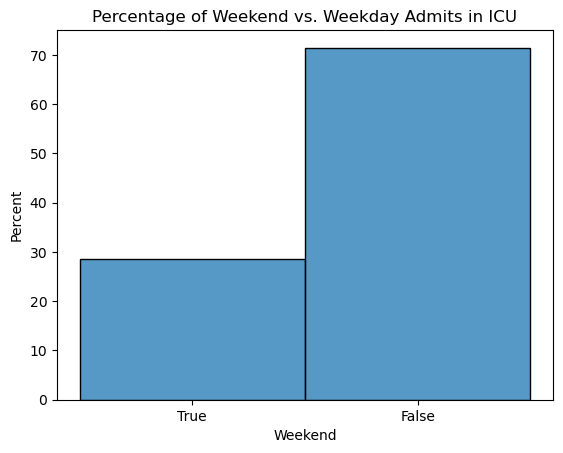

In [ ]:
# Create is_weekend: Saturday (5) or Sunday (6)
icu_adms['is_weekend'] = (pd.to_datetime(icu_adms['intime']).dt.weekday >= 5).astype(int)

sns.histplot(icu_adms['is_weekend'].astype(bool).astype('string'), stat = 'percent', bins=2)
plt.xlabel('Weekend')
plt.ylabel('Percent')
plt.title("Percentage of Weekend vs. Weekday Admits in ICU")
plt.show()

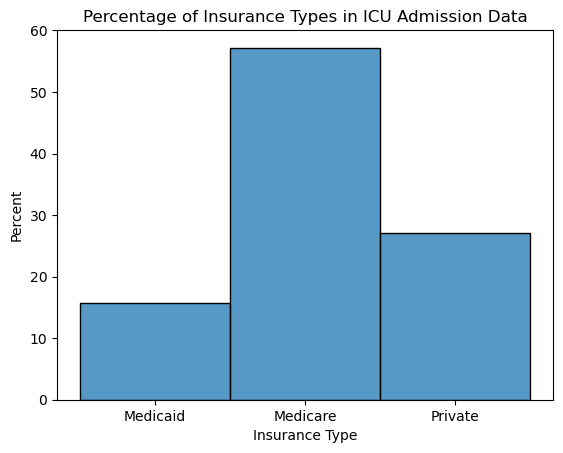

In [ ]:
#basic plot for insurance type
sns.histplot(icu_adms['insurance'], stat = 'percent', bins = 20)
plt.xlabel('Insurance Type')
plt.ylabel('Percent')
plt.title("Percentage of Insurance Types in ICU Admission Data")
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\547349693.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




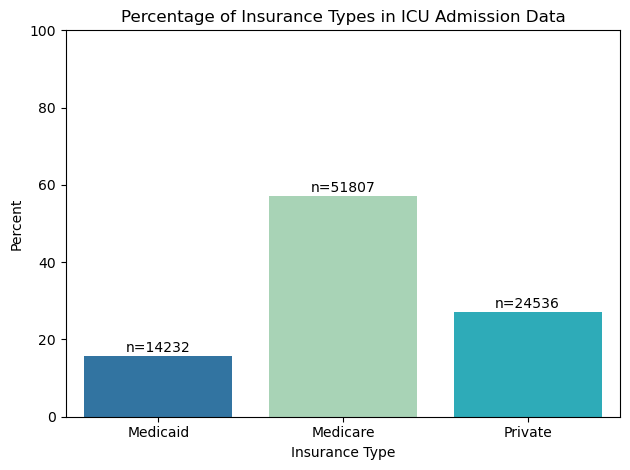

In [ ]:
#plot for insurance type for presentation (stick with color theme, label better, etc.)
color_map = {
    'Medicaid': '#1f77b4',
    'Medicare': '#a1dab4',
    'Private': '#17becf'
}
# Group and get counts
insurance_counts = icu_adms['insurance'].value_counts(normalize=True).sort_index() * 100
absolute_counts = icu_adms['insurance'].value_counts().sort_index()

# Order categories
categories = ['Medicaid', 'Medicare', 'Private']
insurance_counts = insurance_counts.reindex(categories)
absolute_counts = absolute_counts.reindex(categories)

# Create bar plot with spacing (by controlling width & tick alignment)
barplot = sns.barplot(x=insurance_counts.index, y=insurance_counts.values,
                      palette=[color_map[i] for i in categories])

# Annotate counts on top of bars
for i, (percent, count) in enumerate(zip(insurance_counts.values, absolute_counts.values)):
    barplot.text(i, percent + 1, f'n={count}', ha='center')

# Format axes
plt.ylim(0, 100)
plt.ylabel('Percent')
plt.xlabel('Insurance Type')
plt.title('Percentage of Insurance Types in ICU Admission Data')
plt.tight_layout()
plt.show()

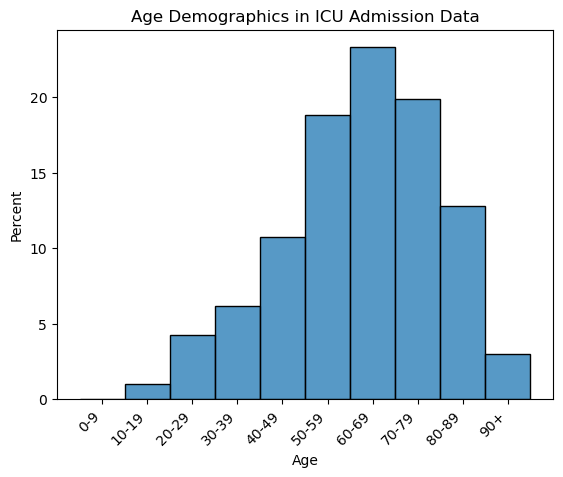

In [ ]:
#basic age distribution plot
sns.histplot(icu_adms['age_group'], stat='percent',bins=20)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Age')
plt.ylabel('Percent')
plt.title("Age Demographics in ICU Admission Data")
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\803682278.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\803682278.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



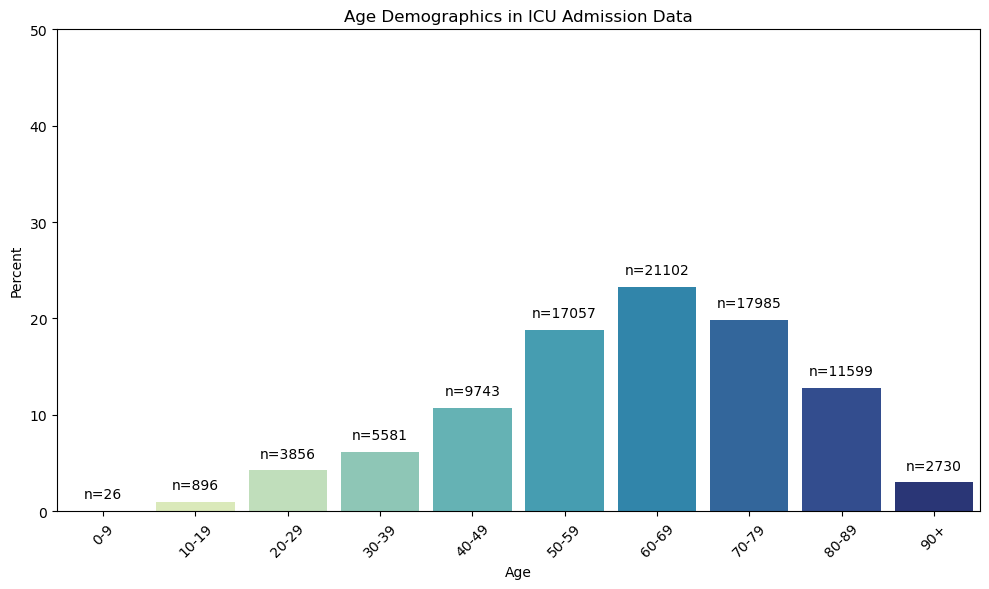

In [ ]:
#nicer plot for presentation to stick with color theme + labels
age_order = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']
icu_adms['age_group'] = pd.Categorical(icu_adms['age_group'], categories=age_order, ordered=True)

age_counts = icu_adms['age_group'].value_counts().reindex(age_order)
age_percent = 100 * age_counts / age_counts.sum()

colors = sns.color_palette("YlGnBu", len(age_order))
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=age_percent.index, y=age_percent.values, palette=colors, width=0.85)

for i, count in enumerate(age_counts):
    ax.text(i, age_percent[i] + 1, f"n={count}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.ylim(0, 50)
plt.xlabel('Age')
plt.ylabel('Percent')
plt.title("Age Demographics in ICU Admission Data")
plt.tight_layout()
plt.show()


C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\3298768896.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



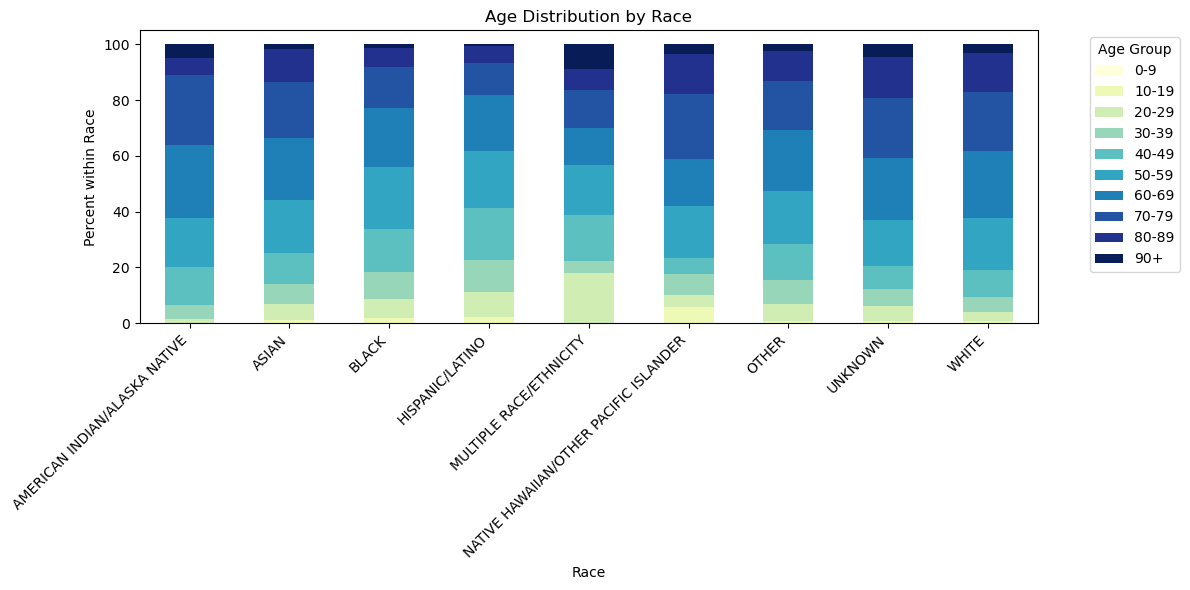

In [ ]:
# stacked bar plot for age and race for presentation
# Ensure age_group is ordered
age_order = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']
icu_adms['age_group'] = pd.Categorical(icu_adms['age_group'], categories=age_order, ordered=True)

# Pivot for plotting
age_race_counts = icu_adms.groupby(['race', 'age_group']).size().unstack().fillna(0)
age_race_percent = age_race_counts.div(age_race_counts.sum(axis=1), axis=0) * 100

# Plot
ax = age_race_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='YlGnBu')

plt.ylabel("Percent within Race")
plt.xlabel("Race")
plt.title("Age Distribution by Race")
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


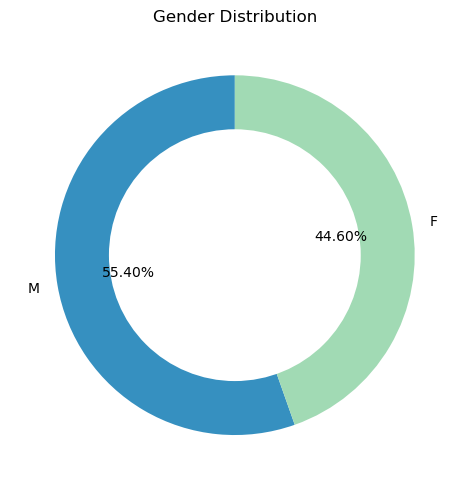

In [ ]:
# Gender distribution
gender_counts = icu_adms['gender'].value_counts()
gender_labels = gender_counts.index.tolist()
gender_sizes = gender_counts.values

# Define colors in label order
gender_colors = ['#a1dab4' if g == 'F' else '#3690c0' for g in gender_labels]

# Donut plot
fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(
    gender_sizes,
    labels=gender_labels,
    autopct='%1.2f%%',
    startangle=90,
    colors=gender_colors  # ← FIXED
)

# Draw inner white circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title("Gender Distribution")
plt.tight_layout()
plt.show()


C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\3857954396.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



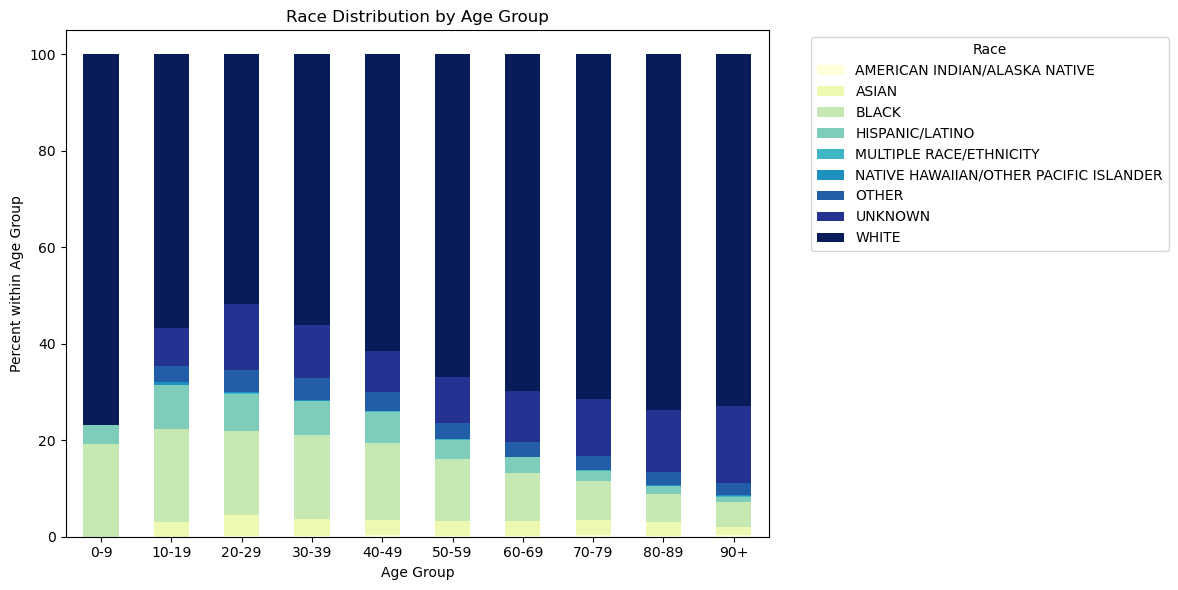

In [ ]:
# Ensure age group ordering
age_order = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']
icu_adms['age_group'] = pd.Categorical(icu_adms['age_group'], categories=age_order, ordered=True)

# Get race x age group counts
race_age_counts = icu_adms.groupby(['age_group', 'race']).size().unstack().fillna(0)

# Convert to percent within each age group
race_age_percent = race_age_counts.div(race_age_counts.sum(axis=1), axis=0) * 100

# Plot
race_age_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='YlGnBu')
plt.ylabel("Percent within Age Group")
plt.xlabel("Age Group")
plt.title("Race Distribution by Age Group")
plt.xticks(rotation=0)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Disparities in ICU Mortality by race, gender, and insurance type

Looking at means and comparing stats before modeling.

- Insurance type and mortality means

In [ ]:
icu_adms.groupby("insurance")["in_icu_mortality"].mean()


insurance
Medicaid    0.066892
Medicare    0.094601
Private     0.057752
Name: in_icu_mortality, dtype: float64

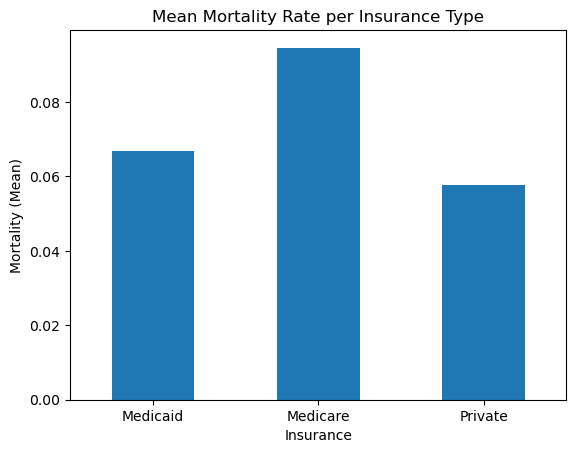

In [ ]:
#basic plot
icu_adms.groupby("insurance")["in_icu_mortality"].mean().plot(kind='bar', title='Mean Mortality Rate per Insurance Type')
plt.xlabel('Insurance')
plt.ylabel('Mortality (Mean)')
plt.xticks(rotation=0) # Keep labels horizontal
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\3611298425.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




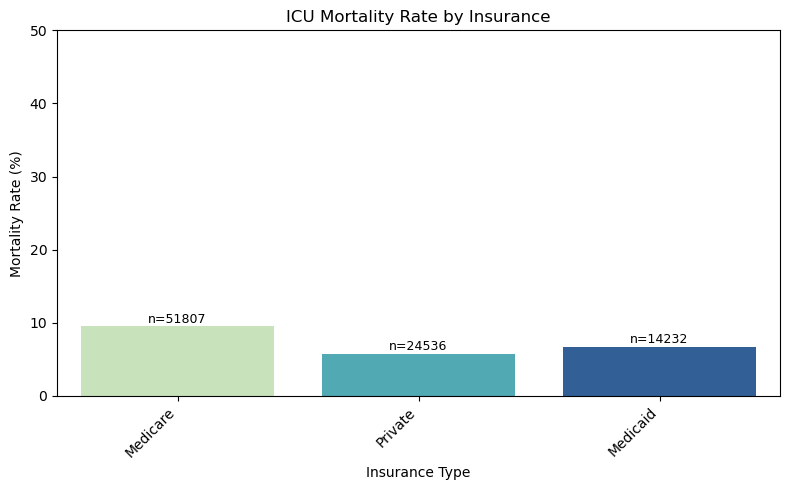

In [ ]:
# plot for presentation
# Get order
insurance_order = icu_adms['insurance'].value_counts().index.tolist()

# Group and calculate
insurance_grouped = icu_adms.groupby("insurance")["in_icu_mortality"]
mortality_rate = (insurance_grouped.mean().reindex(insurance_order) * 100).round(1)
counts = insurance_grouped.count().reindex(insurance_order)

# DataFrame
insurance_df = pd.DataFrame({
    'Insurance': insurance_order,
    'MortalityRate': mortality_rate.values,
    'Count': counts.values
})

# Color palette
colors = sns.color_palette("YlGnBu", n_colors=len(insurance_order))
color_dict = dict(zip(insurance_order, colors))

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=insurance_df,
    x='Insurance',
    y='MortalityRate',
    order=insurance_order,
    palette=[color_dict[i] for i in insurance_order]
)

# Add count labels
for i, row in insurance_df.iterrows():
    ax.text(
        x=i,
        y=row['MortalityRate'] + 0.5,
        s=f"n={int(row['Count'])}",
        ha='center',
        fontsize=9,
        color='black'
    )

# Labels
plt.xlabel('Insurance Type')
plt.ylim(0, 50)
plt.ylabel('Mortality Rate (%)')
plt.title('ICU Mortality Rate by Insurance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


- By race, 'UNKNOWN' is very high. One of the reasons is likely because race is a self reported field so if a patient is admitted and intubated or in critical condition and can't communicate, it's filed as 'UNKNOWN' and due to their condition they have a higher likelihood of mortality?   

**planning to run models with and without 'UNKNOWN' field**

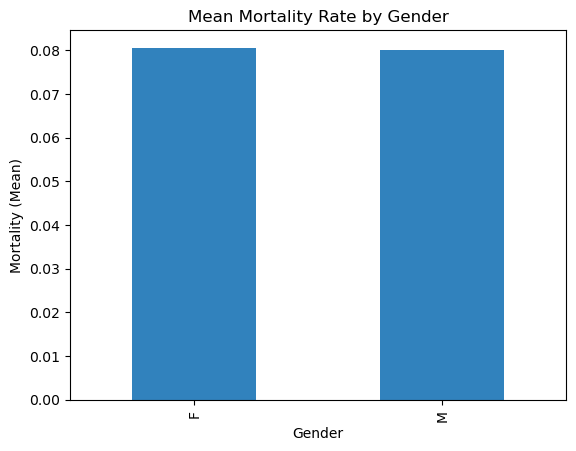

In [ ]:
# basic plot
icu_adms.groupby("gender")["in_icu_mortality"].mean().plot(kind='bar', title='Mean Mortality Rate by Gender', colormap='tab20c')
plt.xlabel('Gender')
plt.ylabel('Mortality (Mean)')
plt.xticks() # Keep labels horizontal
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\2767845615.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




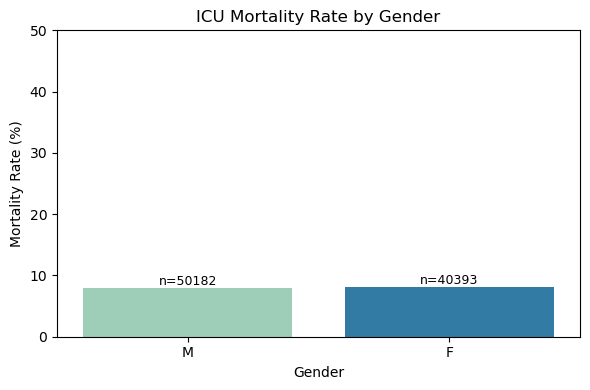

In [ ]:
# plot for presentation
# Get order
gender_order = icu_adms['gender'].value_counts().index.tolist()

# Group and calculate
gender_grouped = icu_adms.groupby("gender")["in_icu_mortality"]
mortality_rate = (gender_grouped.mean().reindex(gender_order) * 100).round(1)
counts = gender_grouped.count().reindex(gender_order)

# DataFrame
gender_df = pd.DataFrame({
    'Gender': gender_order,
    'MortalityRate': mortality_rate.values,
    'Count': counts.values
})

# Color palette
colors = sns.color_palette("YlGnBu", n_colors=len(gender_order))
color_dict = dict(zip(gender_order, colors))

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=gender_df,
    x='Gender',
    y='MortalityRate',
    order=gender_order,
    palette=[color_dict[g] for g in gender_order]
)

# Add count labels
for i, row in gender_df.iterrows():
    ax.text(
        x=i,
        y=row['MortalityRate'] + 0.5,
        s=f"n={int(row['Count'])}",
        ha='center',
        fontsize=9,
        color='black'
    )

# Labels
plt.xlabel('Gender')
plt.ylim(0, 50)
plt.ylabel('Mortality Rate (%)')
plt.title('ICU Mortality Rate by Gender')
plt.tight_layout()
plt.show()


In [ ]:
icu_adms.groupby("race")["in_icu_mortality"].mean()


race
AMERICAN INDIAN/ALASKA NATIVE             0.095745
ASIAN                                     0.084052
BLACK                                     0.071723
HISPANIC/LATINO                           0.062226
MULTIPLE RACE/ETHNICITY                   0.074627
NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER    0.117647
OTHER                                     0.069586
UNKNOWN                                   0.141433
WHITE                                     0.072957
Name: in_icu_mortality, dtype: float64

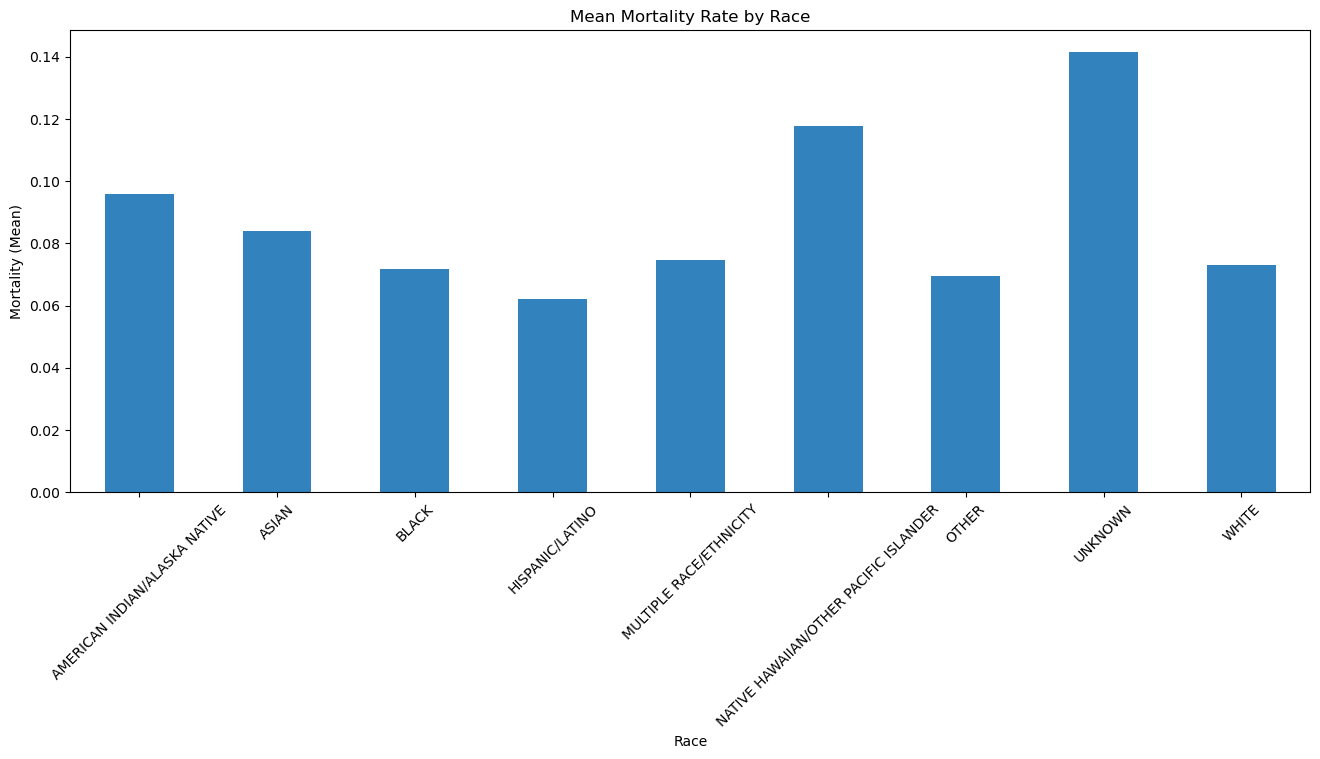

In [ ]:
# basic plot
plt.figure(figsize=(16,6))

icu_adms.groupby("race")["in_icu_mortality"].mean().plot(kind='bar', title='Mean Mortality Rate by Race', colormap='tab20c')
plt.xlabel('Race')
plt.ylabel('Mortality (Mean)')
plt.xticks(rotation=45, fontsize=10) # Keep labels horizontal
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\2867552085.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




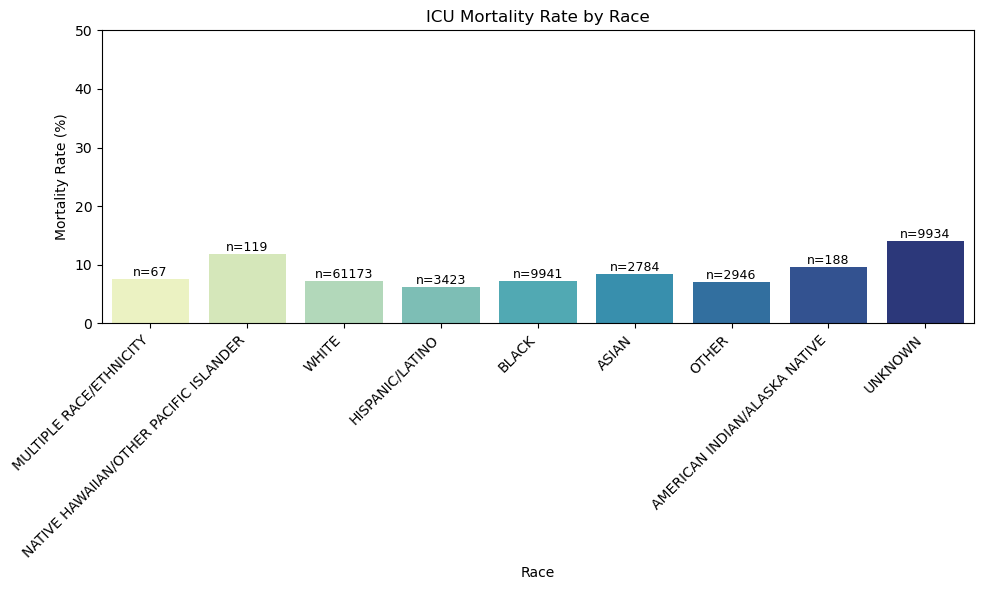

In [ ]:
# for presentation
# Calculate mortality rate and count per race
grouped = icu_adms.groupby("race")["in_icu_mortality"]
mortality_rate = (grouped.mean().reindex(race_order) * 100).round(1)
race_counts = grouped.count().reindex(race_order)

# Create DataFrame for plotting
race_mortality_df = pd.DataFrame({
    'Race': race_order,
    'MortalityRate': mortality_rate.values,
    'Count': race_counts.values
})

# Color palette matching LOS chart
colors = sns.color_palette("YlGnBu", n_colors=len(race_order))
color_dict = dict(zip(race_order, colors))

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=race_mortality_df,
    x='Race',
    y='MortalityRate',
    order=race_order,
    palette=[color_dict[r] for r in race_order]
)

# Add n labels on top of bars
for i, row in race_mortality_df.iterrows():
    ax.text(
        x=i,
        y=row['MortalityRate'] + 0.5,
        s=f"n={int(row['Count'])}",
        ha='center',
        fontsize=9,
        color='black'
    )

# Aesthetics
plt.title("ICU Mortality Rate by Race")
plt.ylim(0, 50)
plt.ylabel("Mortality Rate (%)")
plt.xlabel("Race")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Looking at age because need to consider how age might interact with insurance due to Medicare and whether or not to consider just doing Medicaid vs. Private

In [ ]:
icu_adms.groupby("age_group")["in_icu_mortality"].mean()


C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\171872585.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



age_group
0-9      0.000000
10-19    0.022321
20-29    0.035529
30-39    0.050349
40-49    0.060146
50-59    0.070294
60-69    0.078002
70-79    0.093967
80-89    0.117079
90+      0.129304
Name: in_icu_mortality, dtype: float64

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\878849273.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



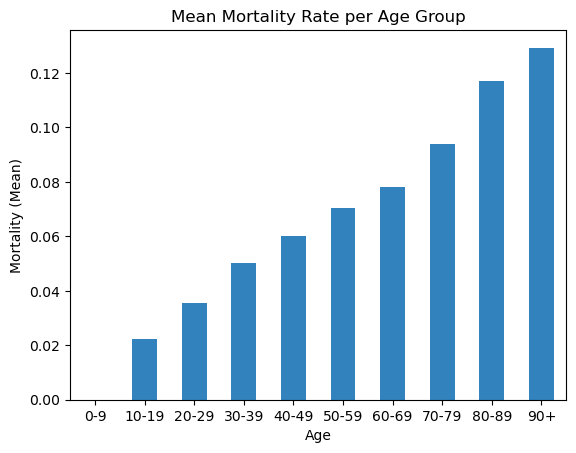

In [ ]:
icu_adms.groupby("age_group")["in_icu_mortality"].mean().plot(kind='bar', title='Mean Mortality Rate per Age Group', colormap='tab20c')
plt.xlabel('Age')
plt.ylabel('Mortality (Mean)')
plt.xticks(rotation=0) # Keep labels horizontal
plt.show()

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\4054860497.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\4054860497.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




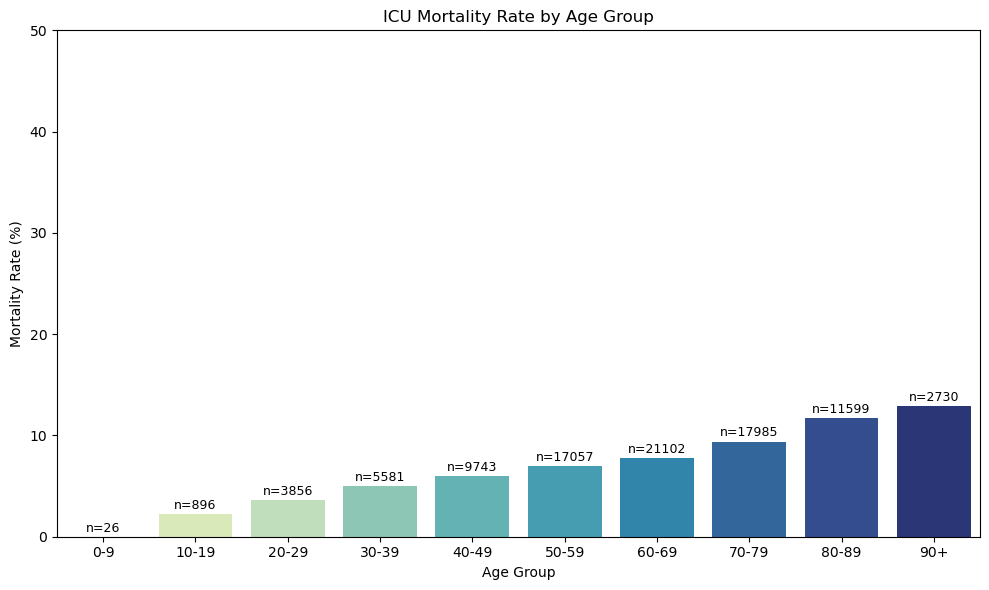

In [ ]:
age_order = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']
icu_adms['age_group'] = pd.Categorical(icu_adms['age_group'], categories=age_order, ordered=True)

# Get counts and percentages
age_counts = icu_adms['age_group'].value_counts().reindex(age_order)
age_percent = 100 * age_counts / age_counts.sum()

# Define color palette
colors = sns.color_palette("YlGnBu", n_colors=len(age_order))
color_dict = dict(zip(age_order, colors))

# Group by age_group not 'age'
grouped = icu_adms.groupby("age_group")["in_icu_mortality"]
mortality_rate = (grouped.mean().reindex(age_order) * 100).round(1)
age_counts = grouped.count().reindex(age_order)

# Create dataframe
age_mortality_df = pd.DataFrame({
    'Age': age_order,
    'MortalityRate': mortality_rate.values,
    'Count': age_counts.values
})

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=age_mortality_df,
    x='Age',
    y='MortalityRate',
    order=age_order,
    palette=[color_dict[r] for r in age_order]
)

# Add n labels on top of bars
for i, row in age_mortality_df.iterrows():
    ax.text(
        x=i,
        y=row['MortalityRate'] + 0.5,
        s=f"n={int(row['Count'])}",
        ha='center',
        fontsize=9,
        color='black'
    )

# Aesthetics
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')
plt.ylim(0, 50)
plt.title('ICU Mortality Rate by Age Group')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Checking significance pre-modeling

- There's a significant difference in average mortality rate between Medicaid and Private insured patients in ICU with a p-value of $0.000346$

In [ ]:
t_statistic, p_value = stats.ttest_ind(icu_adms[icu_adms["insurance"] == "Medicaid"]["in_icu_mortality"],
    icu_adms[icu_adms["insurance"] == "Private"]["in_icu_mortality"], nan_policy = 'omit')
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 3.6218921791151915
P-value: 0.00029282906640432706


In [ ]:
stats.f_oneway(
    icu_adms[icu_adms["insurance"] == "Medicare"]["in_icu_mortality"],
    icu_adms[icu_adms["insurance"] == "Medicaid"]["in_icu_mortality"],
    icu_adms[icu_adms["insurance"] == "Private"]["in_icu_mortality"], nan_policy = 'omit'
)

F_onewayResult(statistic=np.float64(174.2462766310351), pvalue=np.float64(2.9581244692439374e-76))

#### Modeling  
- The tests above only showed that there exists a difference. Will do stats modeling to understand how / to what degree through regression coefficients.  
- Starting with just a simple logit model (because outcome variable is binary) including the 4 variables of interest

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize numeric columns
scaler = StandardScaler()
icu_adms['age_scaled'] = scaler.fit_transform(icu_adms[['age']])
icu_adms['comorbidity_scaled'] = scaler.fit_transform(icu_adms[['comorbidity_score']])

# Refit with scaled variables
mortality_model = smf.logit(
    formula='in_icu_mortality ~ age_scaled + gender + insurance + race + comorbidity_scaled + first_careunit',
    data=icu_adms
).fit(maxiter=200, method='bfgs')  # BFGS is more stable

mortality_model.summary()

         Current function value: 0.257202
         Iterations: 200
         Function evaluations: 201
         Gradient evaluations: 201


c:\Users\atrey\miniconda3\Lib\site-packages\scipy\optimize\_optimize.py:1291: OptimizeWarning:

Maximum number of iterations has been exceeded.

c:\Users\atrey\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       in_icu_mortality   No. Observations:                90575
Model:                          Logit   Df Residuals:                    90545
Method:                           MLE   Df Model:                           29
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                 0.07950
Time:                        21:53:31   Log-Likelihood:                -23296.
converged:                      False   LL-Null:                       -25308.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -3.3047      0.250    -13.229      0.000      -3.794      -2.815
gender[T.M]                                                            0.0134      0.025      0.526      0.599      -0.037       0.063
insurance[T.Medicare]                                                  0.0859      0.042      2.029      0.042       0.003       0.169
insurance[T.Private]                                                  -0.0232      0.045     -0.516      0.606      -0.111       0.065
race[T.ASIAN]                                                         -0.1366      0.253     -0.541      0.589      -0.632       0.359
race[T.BLACK]                                                         -0.3346      0.246     -1.361      0.174      -0.816       0.147
race[T.HISPANIC/LATINO]                                               -0.3339      0.253     -1.318      0.187      -0.830       0.163
race[T.MULTIPLE RACE/ETHNICITY]                                       -0.2518      0.566     -0.445      0.656      -1.360       0.857
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         0.2835      0.381      0.744      0.457      -0.464       1.031
race[T.OTHER]                                                         -0.2434      0.254     -0.959      0.337      -0.741       0.254
race[T.UNKNOWN]                                                        0.5994      0.245      2.451      0.014       0.120       1.079
race[T.WHITE]                                                         -0.2766      0.243     -1.138      0.255      -0.753       0.200
first_careunit[T.Coronary Care Unit (CCU)]                             0.9602      0.058     16.659      0.000       0.847       1.073
first_careunit[T.Intensive Care Unit (ICU)]                            3.0886      0.387      7.971      0.000       2.329       3.848
first_careunit[T.Med/Surg]                                            -0.0165      5.691     -0.003      0.998     -11.171      11.138
first_careunit[T.Medical Intensive Care Unit (MICU)]                   1.2173      0.053     23.034      0.000       1.114       1.321
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]     0.9778      0.056     17.500      0.000       0.868       1.087
first_careunit[T.Medicine]                                             1.1007      0.931      1.183      0.237      -0.723       2.925
first_careunit[T.Medicine/Cardiology Intermediate]                    -0.0768      2.814     -0.027      0.978      -5.592       5.439
first_careunit[T.Neuro Intermediate]                                  -1.2912      0.147     -8.787      0.000      -1.579      -1.003
first_careunit[T.Neuro Stepdown]                                      -1.2069      0.278     -4.335      0.000      -1.753      -0.661
f

In [ ]:
#basic model with the 4 features of interest
mortality_model = smf.logit(formula='in_icu_mortality ~ age + gender + insurance + race + comorbidity_score + first_careunit', data=icu_adms).fit(maxiter=200, method='bfgs')
mortality_model.summary()

         Current function value: 0.257209
         Iterations: 200
         Function evaluations: 203
         Gradient evaluations: 203


c:\Users\atrey\miniconda3\Lib\site-packages\scipy\optimize\_optimize.py:1291: OptimizeWarning:

Maximum number of iterations has been exceeded.

c:\Users\atrey\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       in_icu_mortality   No. Observations:                90575
Model:                          Logit   Df Residuals:                    90545
Method:                           MLE   Df Model:                           29
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                 0.07948
Time:                        21:54:35   Log-Likelihood:                -23297.
converged:                      False   LL-Null:                       -25308.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -4.6787      0.252    -18.554      0.000      -5.173      -4.184
gender[T.M]                                                            0.0139      0.025      0.544      0.586      -0.036       0.064
insurance[T.Medicare]                                                  0.0816      0.042      1.928      0.054      -0.001       0.165
insurance[T.Private]                                                  -0.0255      0.045     -0.567      0.571      -0.114       0.063
race[T.ASIAN]                                                         -0.1859      0.249     -0.746      0.456      -0.674       0.303
race[T.BLACK]                                                         -0.3782      0.242     -1.560      0.119      -0.853       0.097
race[T.HISPANIC/LATINO]                                               -0.3481      0.250     -1.394      0.163      -0.837       0.141
race[T.MULTIPLE RACE/ETHNICITY]                                       -0.4086      0.587     -0.696      0.487      -1.560       0.743
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         0.1914      0.383      0.499      0.618      -0.560       0.943
race[T.OTHER]                                                         -0.2546      0.250     -1.018      0.309      -0.745       0.236
race[T.UNKNOWN]                                                        0.5602      0.241      2.324      0.020       0.088       1.033
race[T.WHITE]                                                         -0.3171      0.240     -1.323      0.186      -0.787       0.152
first_careunit[T.Coronary Care Unit (CCU)]                             0.9791      0.058     16.923      0.000       0.866       1.093
first_careunit[T.Intensive Care Unit (ICU)]                            3.1372      0.387      8.108      0.000       2.379       3.896
first_careunit[T.Med/Surg]                                            -0.0148      5.646     -0.003      0.998     -11.080      11.050
first_careunit[T.Medical Intensive Care Unit (MICU)]                   1.2347      0.053     23.248      0.000       1.131       1.339
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]     0.9958      0.056     17.744      0.000       0.886       1.106
first_careunit[T.Medicine]                                             0.9966      0.975      1.022      0.307      -0.915       2.908
first_careunit[T.Medicine/Cardiology Intermediate]                    -0.0698      2.824     -0.025      0.980      -5.605       5.466
first_careunit[T.Neuro Intermediate]                                  -1.2923      0.148     -8.728      0.000      -1.583      -1.002
first_careunit[T.Neuro Stepdown]                                      -1.1988      0.279     -4.292      0.000      -1.746      -0.651
f

In [ ]:
#extracting coefficients and odds ratio for interpretation
params = mortality_model.params.drop("Intercept")

odds_ratios = np.exp(params)
odds_ratios


gender[T.M]                                                            1.013968
insurance[T.Medicare]                                                  1.085007
insurance[T.Private]                                                   0.974816
race[T.ASIAN]                                                          0.830371
race[T.BLACK]                                                          0.685108
race[T.HISPANIC/LATINO]                                                0.706047
race[T.MULTIPLE RACE/ETHNICITY]                                        0.664606
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         1.210898
race[T.OTHER]                                                          0.775265
race[T.UNKNOWN]                                                        1.751048
race[T.WHITE]                                                          0.728265
first_careunit[T.Coronary Care Unit (CCU)]                             2.662140
first_careunit[T.Intensive Care Unit (IC

In [ ]:
mortality_model.pvalues

Intercept                                                              7.573106e-77
gender[T.M]                                                            5.861027e-01
insurance[T.Medicare]                                                  5.390057e-02
insurance[T.Private]                                                   5.706187e-01
race[T.ASIAN]                                                          4.558293e-01
race[T.BLACK]                                                          1.186533e-01
race[T.HISPANIC/LATINO]                                                1.632606e-01
race[T.MULTIPLE RACE/ETHNICITY]                                        4.866973e-01
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         6.177732e-01
race[T.OTHER]                                                          3.087886e-01
race[T.UNKNOWN]                                                        2.010009e-02
race[T.WHITE]                                                          1.856

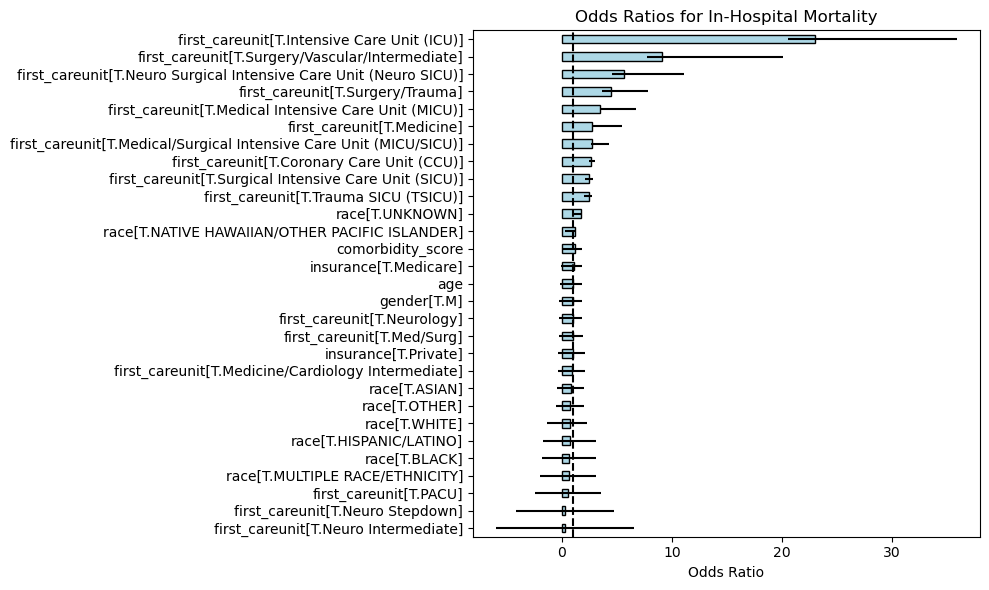

In [ ]:
# Extract odds ratios and confidence intervals
params = mortality_model.params.drop("Intercept")
conf = mortality_model.conf_int().loc[params.index]

# Odds ratios and CI bounds
odds_ratios = np.exp(params)
ci_lower = np.exp(conf[0])
ci_upper = np.exp(conf[1])
errors = [odds_ratios - ci_lower, ci_upper - odds_ratios]

# Plot
plt.figure(figsize=(10, 6))
odds_ratios.sort_values().plot(kind='barh', xerr=np.abs(np.log([errors[0].sort_values(), errors[1].sort_values()])),
                               color='lightblue', edgecolor='black')
plt.axvline(1, color='black', linestyle='--')
plt.title("Odds Ratios for In-Hospital Mortality")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

becasue failed to converge

In [ ]:
glm_model = smf.glm(
    'in_icu_mortality ~ age + gender + insurance + race + comorbidity_score + first_careunit',
    data=icu_adms,
    family=sm.families.Binomial()
).fit()

glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       in_icu_mortality   No. Observations:                90575
Model:                            GLM   Df Residuals:                    90545
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23291.
Date:                Sun, 23 Nov 2025   Deviance:                       46583.
Time:                        21:55:18   Pearson chi2:                 8.73e+04
No. Iterations:                    20   Pseudo R-squ. (CS):            0.04355
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -4.8095      0.264    -18.232      0.000      -5.326      -4.292
gender[T.M]                                                            0.0140      0.025      0.548      0.584      -0.036       0.064
insurance[T.Medicare]                                                  0.0765      0.042      1.809      0.070      -0.006       0.159
insurance[T.Private]                                                  -0.0326      0.045     -0.726      0.468      -0.121       0.055
race[T.ASIAN]                                                         -0.0351      0.261     -0.134      0.893      -0.546       0.476
race[T.BLACK]                                                         -0.2451      0.254     -0.963      0.335      -0.744       0.254
race[T.HISPANIC/LATINO]                                               -0.2352      0.262     -0.899      0.368      -0.748       0.277
race[T.MULTIPLE RACE/ETHNICITY]                                        0.0384      0.533      0.072      0.943      -1.007       1.084
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         0.3529      0.388      0.908      0.364      -0.409       1.114
race[T.OTHER]                                                         -0.1367      0.262     -0.522      0.602      -0.650       0.377
race[T.UNKNOWN]                                                        0.6939      0.253      2.741      0.006       0.198       1.190
race[T.WHITE]                                                         -0.1838      0.252     -0.730      0.465      -0.677       0.310
first_careunit[T.Coronary Care Unit (CCU)]                             0.9859      0.058     17.013      0.000       0.872       1.099
first_careunit[T.Intensive Care Unit (ICU)]                            2.7988      0.398      7.025      0.000       2.018       3.580
first_careunit[T.Med/Surg]                                           -18.1643   2.92e+04     -0.001      1.000   -5.73e+04    5.73e+04
first_careunit[T.Medical Intensive Care Unit (MICU)]                   1.2402      0.053     23.305      0.000       1.136       1.345
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]     1.0018      0.056     17.819      0.000       0.892       1.112
first_careunit[T.Medicine]                                             2.1232      0.662      3.206      0.001       0.825       3.421
first_careunit[T.Medicine/Cardiology Intermediate]                   -19.8725   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
first_careunit[T.Neuro Intermediate]                                  -1.2962      0.149     -8.716      0.000   

In [ ]:
glm_model.pvalues

Intercept                                                              2.862020e-74
gender[T.M]                                                            5.838036e-01
insurance[T.Medicare]                                                  7.047740e-02
insurance[T.Private]                                                   4.678702e-01
race[T.ASIAN]                                                          8.931090e-01
race[T.BLACK]                                                          3.353862e-01
race[T.HISPANIC/LATINO]                                                3.684557e-01
race[T.MULTIPLE RACE/ETHNICITY]                                        9.425345e-01
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         3.637056e-01
race[T.OTHER]                                                          6.017914e-01
race[T.UNKNOWN]                                                        6.120641e-03
race[T.WHITE]                                                          4.653

c:\Users\atrey\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp



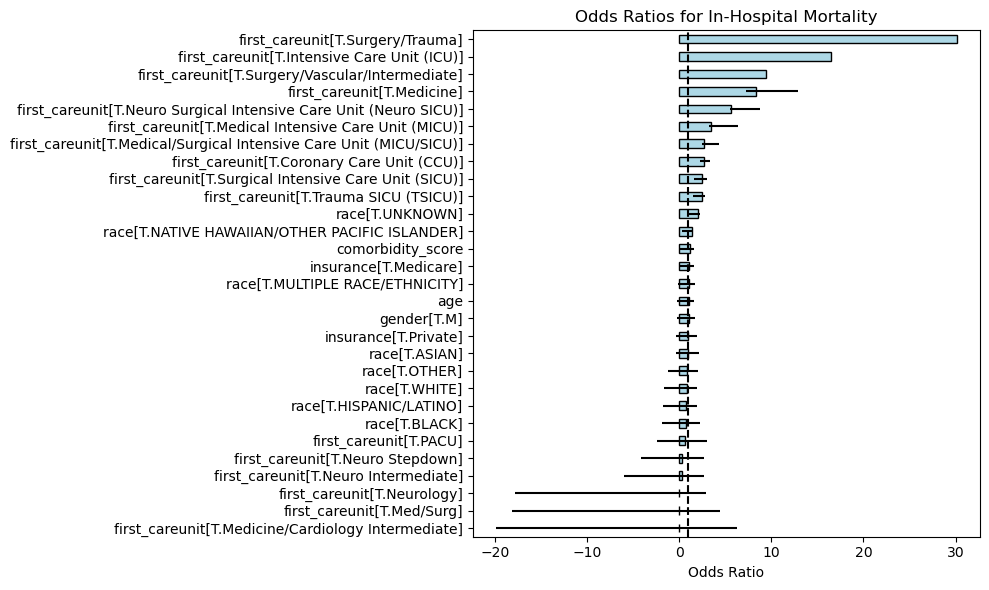

In [ ]:
# Extract odds ratios and confidence intervals
params = glm_model.params.drop("Intercept")
conf = glm_model.conf_int().loc[params.index]

# Odds ratios and CI bounds
odds_ratios = np.exp(params)
ci_lower = np.exp(conf[0])
ci_upper = np.exp(conf[1])
errors = [odds_ratios - ci_lower, ci_upper - odds_ratios]

# Plot
plt.figure(figsize=(10, 6))
odds_ratios.sort_values().plot(kind='barh', xerr=np.abs(np.log([errors[0].sort_values(), errors[1].sort_values()])),
                               color='lightblue', edgecolor='black')
plt.axvline(1, color='black', linestyle='--')
plt.title("Odds Ratios for In-Hospital Mortality")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

**takeaways**:  
- comorbidities and ICU unit are significant
- Race UNKNOWN is also important

**Try and remove UNKNOWN race**

In [ ]:
known_race = icu_adms[icu_adms["race"] != "UNKNOWN"]

In [ ]:
mortality_model_known = smf.logit(formula='in_icu_mortality ~ age + gender + insurance + race + comorbidity_score + first_careunit ', data=known_race).fit()
mortality_model_known.summary()

Optimization terminated successfully.
         Current function value: 0.242271
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       in_icu_mortality   No. Observations:                80641
Model:                          Logit   Df Residuals:                    80613
Method:                           MLE   Df Model:                           27
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                 0.07049
Time:                        21:55:33   Log-Likelihood:                -19537.
converged:                       True   LL-Null:                       -21019.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -4.9193      0.267    -18.397      0.000      -5.443      -4.395
gender[T.M]                                                            0.0190      0.028      0.677      0.498      -0.036       0.074
insurance[T.Medicare]                                                  0.1203      0.048      2.527      0.012       0.027       0.214
insurance[T.Private]                                                   0.0031      0.051      0.060      0.952      -0.098       0.104
race[T.ASIAN]                                                         -0.0348      0.261     -0.133      0.894      -0.547       0.477
race[T.BLACK]                                                         -0.2402      0.255     -0.943      0.346      -0.739       0.259
race[T.HISPANIC/LATINO]                                               -0.2190      0.262     -0.836      0.403      -0.732       0.294
race[T.MULTIPLE RACE/ETHNICITY]                                        0.0553      0.534      0.104      0.917      -0.991       1.102
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         0.3535      0.389      0.908      0.364      -0.410       1.117
race[T.OTHER]                                                         -0.1361      0.262     -0.519      0.604      -0.650       0.378
race[T.WHITE]                                                         -0.1899      0.252     -0.753      0.451      -0.684       0.304
first_careunit[T.Coronary Care Unit (CCU)]                             0.9457      0.066     14.376      0.000       0.817       1.075
first_careunit[T.Intensive Care Unit (ICU)]                            3.0205      0.436      6.933      0.000       2.167       3.874
first_careunit[T.Med/Surg]                                           -28.1037   6.79e+06  -4.14e-06      1.000   -1.33e+07    1.33e+07
first_careunit[T.Medical Intensive Care Unit (MICU)]                   1.1797      0.060     19.575      0.000       1.062       1.298
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]     0.9852      0.063     15.658      0.000       0.862       1.109
first_careunit[T.Medicine]                                             2.4275      0.799      3.037      0.002       0.861       3.994
first_careunit[T.Neuro Intermediate]                                  -1.2130      0.164     -7.377      0.000      -1.535      -0.891
first_careunit[T.Neuro Stepdown]                                      -1.2373      0.323     -3.835      0.000      -1.870      -0.605
first_careunit[T.Neuro Surgical Intensive Care Unit (Neuro SICU)]      1.7157      0.098     17.574      0.000       1.524       1.907
first_careunit[T.Neurology]                                          -27.7322   6.68e+06  -4.15e-06      1.000   -1.31e+07    1.31e+07
f

c:\Users\atrey\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

overflow encountered in exp



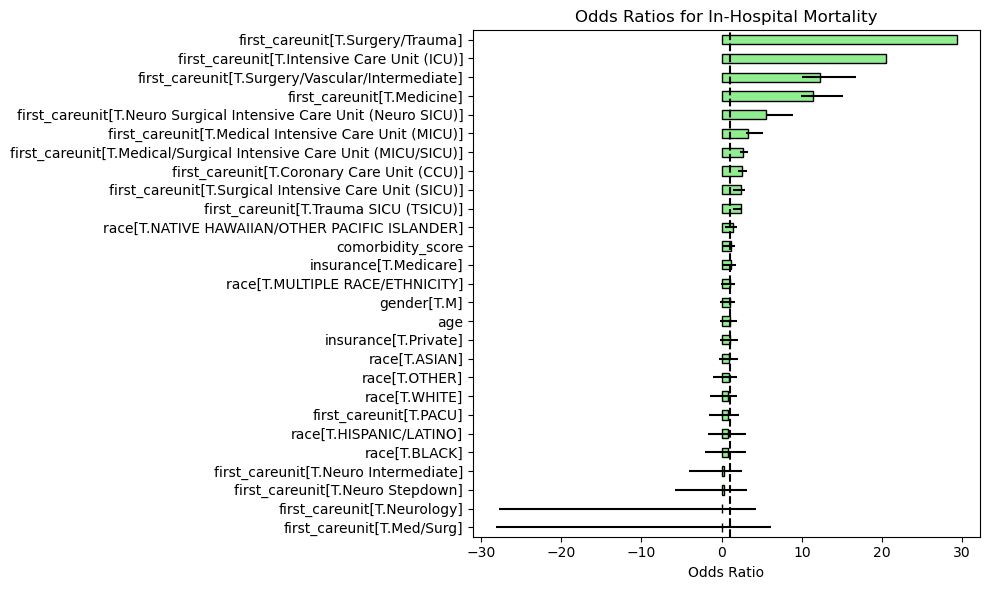

In [ ]:
# Extract odds ratios and confidence intervals
params = mortality_model_known.params.drop("Intercept")
conf = mortality_model_known.conf_int().loc[params.index]

# Odds ratios and CI bounds
odds_ratios = np.exp(params)
ci_lower = np.exp(conf[0])
ci_upper = np.exp(conf[1])
errors = [odds_ratios - ci_lower, ci_upper - odds_ratios]

# Plot
plt.figure(figsize=(10, 6))
odds_ratios.sort_values().plot(kind='barh', xerr=np.abs(np.log([errors[0].sort_values(), errors[1].sort_values()])),
                               color='lightgreen', edgecolor='black')
plt.axvline(1, color='black', linestyle='--')
plt.title("Odds Ratios for In-Hospital Mortality")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

- Reduced the Pseudo-R^2 and other race don't have significant effects. But overall didn't have significant effects on the model suggesting it's fine to keep overall and isn't driving results

Just Medicaid and Private Insurance

In [ ]:
subset_icu = icu_adms[icu_adms['insurance'].isin(['Medicaid', 'Private'])].copy()
subset_icu['insurance'] = subset_icu['insurance'].astype('category')
subset_icu['insurance'] = subset_icu['insurance'].cat.reorder_categories(['Private', 'Medicaid'])



mortality_insurance = smf.logit("in_icu_mortality ~ insurance + age + race + gender + comorbidity_score + first_careunit", data=icu_adms[icu_adms['insurance'].isin(['Medicaid', 'Private'])]).fit()
mortality_insurance.summary()

         Current function value: 0.206222
         Iterations: 35


c:\Users\atrey\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       in_icu_mortality   No. Observations:                38758
Model:                          Logit   Df Residuals:                    38732
Method:                           MLE   Df Model:                           25
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                  0.1036
Time:                        21:57:11   Log-Likelihood:                -7992.8
converged:                      False   LL-Null:                       -8916.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -4.9692      0.426    -11.668      0.000      -5.804      -4.135
insurance[T.Private]                                                  -0.0038      0.047     -0.081      0.935      -0.095       0.087
race[T.ASIAN]                                                         -0.0807      0.417     -0.194      0.847      -0.898       0.737
race[T.BLACK]                                                         -0.3336      0.410     -0.814      0.416      -1.137       0.470
race[T.HISPANIC/LATINO]                                               -0.3952      0.418     -0.946      0.344      -1.214       0.424
race[T.MULTIPLE RACE/ETHNICITY]                                      -50.1322   5.12e+10  -9.79e-10      1.000      -1e+11       1e+11
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         0.3378      0.664      0.509      0.611      -0.963       1.639
race[T.OTHER]                                                         -0.1847      0.421     -0.438      0.661      -1.011       0.641
race[T.UNKNOWN]                                                        0.7832      0.407      1.922      0.055      -0.015       1.582
race[T.WHITE]                                                         -0.2958      0.406     -0.729      0.466      -1.091       0.499
gender[T.M]                                                            0.0326      0.045      0.726      0.468      -0.055       0.121
first_careunit[T.Coronary Care Unit (CCU)]                             0.9336      0.108      8.660      0.000       0.722       1.145
first_careunit[T.Intensive Care Unit (ICU)]                            2.1475      1.094      1.963      0.050       0.003       4.292
first_careunit[T.Medical Intensive Care Unit (MICU)]                   1.2916      0.094     13.692      0.000       1.107       1.476
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]     1.0037      0.100     10.055      0.000       0.808       1.199
first_careunit[T.Medicine]                                           -16.9643   1.12e+04     -0.002      0.999   -2.19e+04    2.19e+04
first_careunit[T.Neuro Intermediate]                                  -1.7895      0.314     -5.697      0.000      -2.405      -1.174
first_careunit[T.Neuro Stepdown]                                      -2.0306      0.714     -2.844      0.004      -3.430      -0.631
first_careunit[T.Neuro Surgical Intensive Care Unit (Neuro SICU)]      1.8207      0.139     13.103      0.000       1.548       2.093
first_careunit[T.PACU]                                                -0.3571      1.020     -0.350      0.726      -2.356       1.641
first_careunit[T.Surgery/Trauma]                                     -10.8011   1190.399     -0.009      0.993   -2343.939    2322.337
f

### Disparities in ICU Length of Stay (LOS) by gender, race, and insurance type

#### Exploratory stats

In [ ]:
icu_adms.dropna(subset = ['los'], inplace=True) # drop nulls

In [ ]:
icu_adms.groupby("gender")["los"].describe()


count      mean       std       min       25%       50%       75%  \
gender                                                                        
F       40387.0  3.521597  5.192036  0.001447  1.067731  1.947488  3.805457   
M       50174.0  3.740993  5.623129  0.001250  1.125350  1.994080  3.930683   

               max  
gender              
F       159.666806  
M       226.403079

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\2342740602.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




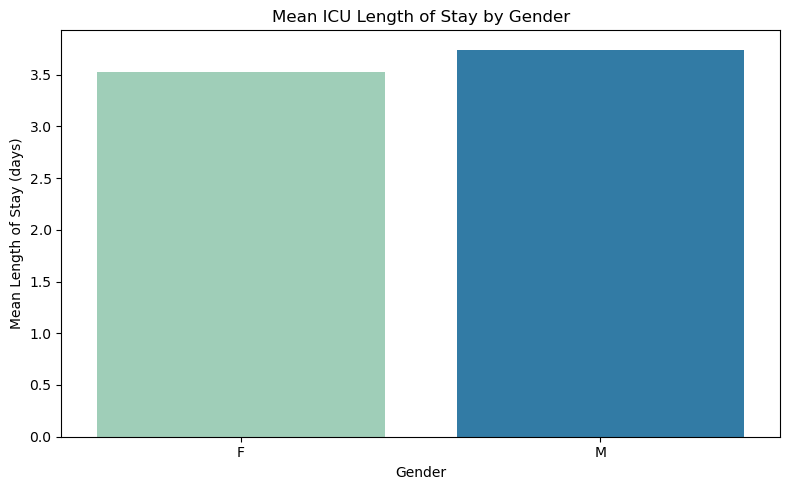

In [ ]:


# Bar plot: Mean LOS by gender
gen_los = icu_adms.groupby("gender")["los"].mean().sort_values()
plt.figure(figsize=(8,5))
sns.barplot(x=gen_los.index, y=gen_los.values, palette="YlGnBu")
plt.title("Mean ICU Length of Stay by Gender")
plt.ylabel("Mean Length of Stay (days)")
plt.xlabel("Gender")
plt.xticks()
plt.tight_layout()
plt.show()


In [ ]:
icu_adms.groupby("race")["los"].mean()


race
AMERICAN INDIAN/ALASKA NATIVE             4.288333
ASIAN                                     3.646710
BLACK                                     3.639351
HISPANIC/LATINO                           3.565202
MULTIPLE RACE/ETHNICITY                   2.663495
NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER    3.474457
OTHER                                     3.764361
UNKNOWN                                   4.568579
WHITE                                     3.491322
Name: los, dtype: float64

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\3765444811.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




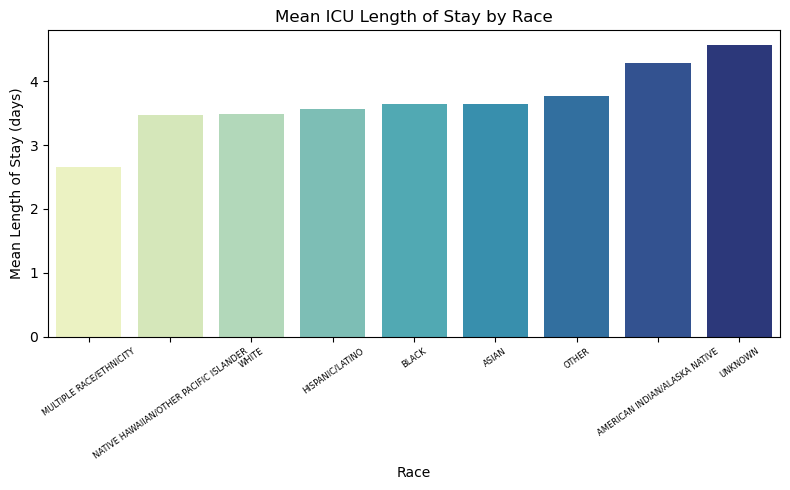

In [ ]:
# Bar plot: Mean LOS by race
race_los = icu_adms.groupby("race")["los"].mean().sort_values()
plt.figure(figsize=(8,5))
sns.barplot(x=race_los.index, y=race_los.values, palette="YlGnBu")
plt.title("Mean ICU Length of Stay by Race")
plt.ylabel("Mean Length of Stay (days)")
plt.xlabel("Race")
plt.xticks(rotation=35, fontsize=6)
plt.tight_layout()
plt.show()

In [ ]:
icu_adms.groupby("insurance")["los"].mean()


insurance
Medicaid    3.792790
Medicare    3.603912
Private     3.639213
Name: los, dtype: float64

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\2732232863.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




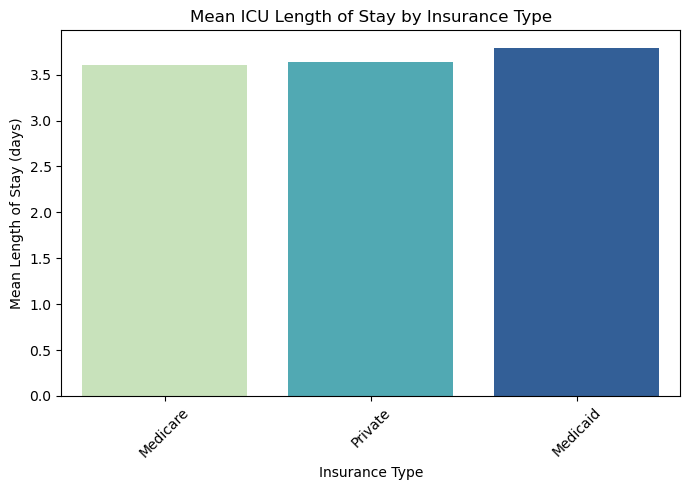

In [ ]:
# Bar plot: Mean LOS by insurance
insurance_los = icu_adms.groupby("insurance")["los"].mean().sort_values()
plt.figure(figsize=(7,5))
sns.barplot(x=insurance_los.index, y=insurance_los.values, palette="YlGnBu")
plt.title("Mean ICU Length of Stay by Insurance Type")
plt.ylabel("Mean Length of Stay (days)")
plt.xlabel("Insurance Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\742343323.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\atrey\AppData\Local\Temp\ipykernel_20892\742343323.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




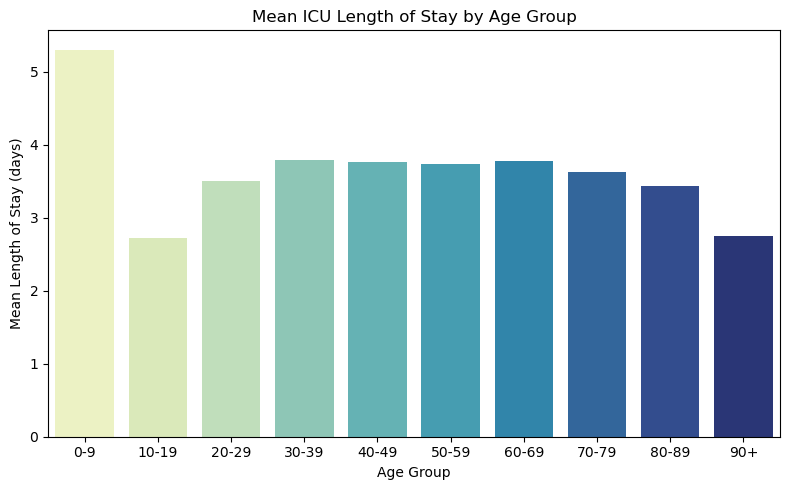

In [ ]:
# Bar plot: Mean LOS by age
age_los = icu_adms.groupby("age_group")["los"].mean().sort_values()
plt.figure(figsize=(8,5))
sns.barplot(x=age_los.index, y=age_los.values, palette="YlGnBu")
plt.title("Mean ICU Length of Stay by Age Group")
plt.ylabel("Mean Length of Stay (days)")
plt.xlabel("Age Group")
plt.xticks()
plt.tight_layout()
plt.show()


**ANOVA test to check for difference in mean LOS**  
- p-value of $0.00126 < 0.05$ suggesting that there is a significant difference in mean LOS by insurance type

In [ ]:
stats.f_oneway(
    icu_adms[icu_adms["insurance"] == "Medicare"]["los"],
    icu_adms[icu_adms["insurance"] == "Medicaid"]["los"],
    icu_adms[icu_adms["insurance"] == "Private"]["los"], nan_policy = 'omit'
)


F_onewayResult(statistic=np.float64(6.747540847640445), pvalue=np.float64(0.0011743527508018914))

**T-test for difference in mean LOS by just Medicaid vs. Private insurance**  
Also significant with p value $0.013$

In [ ]:
t_statistic, p_value = stats.ttest_ind(icu_adms[icu_adms["insurance"] == "Medicaid"]["los"],
    icu_adms[icu_adms["insurance"] == "Private"]["los"], nan_policy = 'omit')
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 2.4887805969992183
P-value: 0.012822368226877599


#### Modeling  
- Run basic Ordinary Least Squares Regression (OLS)  
- Check diagnostics (e.g. residuals, QQ plot) for assumptions  
- Try log transformation

In [ ]:
model_los = smf.ols(formula='los ~ age + gender + insurance + race + comorbidity_score', data=icu_adms).fit()
model_los.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     57.96
Date:                Sun, 23 Nov 2025   Prob (F-statistic):          5.77e-152
Time:                        21:56:02   Log-Likelihood:            -2.8145e+05
No. Observations:               90561   AIC:                         5.629e+05
Df Residuals:                   90547   BIC:                         5.631e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          4.2601      0.403     10.566      0.000       3.470       5.050
gender[T.M]                                        0.1804      0.036      4.957      0.000       0.109       0.252
insurance[T.Medicare]                             -0.0522      0.059     -0.891      0.373      -0.167       0.063
insurance[T.Private]                              -0.0675      0.058     -1.161      0.246      -0.182       0.047
race[T.ASIAN]                                     -0.6099      0.408     -1.495      0.135      -1.410       0.190
race[T.BLACK]                                     -0.6715      0.399     -1.684      0.092      -1.453       0.110
race[T.HISPANIC/LATINO]                           -0.7463      0.406     -1.839      0.066      -1.542       0.049
race[T.MULTIPLE RACE/ETHNICITY]                   -1.5057      0.770     -1.954      0.051      -3.016       0.004
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]    -0.7122      0.634     -1.123      0.261      -1.955       0.531
race[T.OTHER]                                     -0.4704      0.407     -1.155      0.248      -1.269       0.328
race[T.UNKNOWN]                                    0.4129      0.399      1.036      0.300      -0.369       1.194
race[T.WHITE]                                     -0.7249      0.396     -1.833      0.067      -1.500       0.050
age                                               -0.0072      0.001     -5.592      0.000      -0.010      -0.005
comorbidity_score                                  0.1514      0.008     18.686      0.000       0.136       0.167
==============================================================================
Omnibus:                   110458.874   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32292160.073
Skew:                           6.326   Prob(JB):                         0.00
Kurtosis:                      94.640   Cond. No.                     4.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Nothing too significant - Slight reduced LOS with being white and also as age increases LOS slightly decreases? (could be because mortality?)  

- Checking residuals plot and distribution for assumptions for OLS. Seems to fail homoscedasticity and normality of residuals distribution.

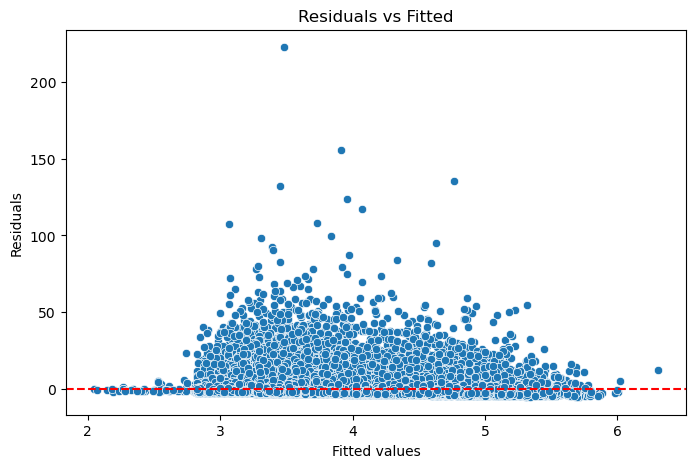

In [ ]:
# Get residuals and predicted values directly
residuals = model_los.resid
fitted = model_los.fittedvalues

# residuals plot to check spread
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

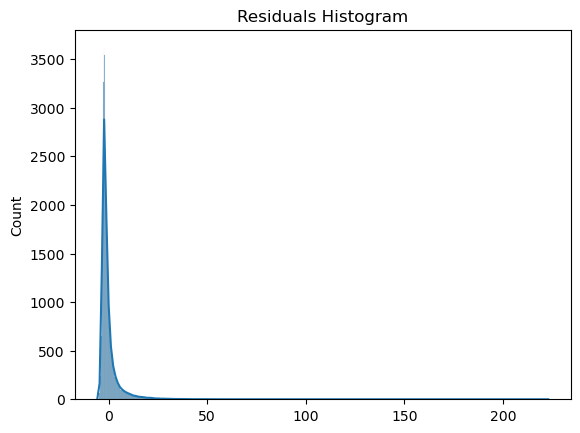

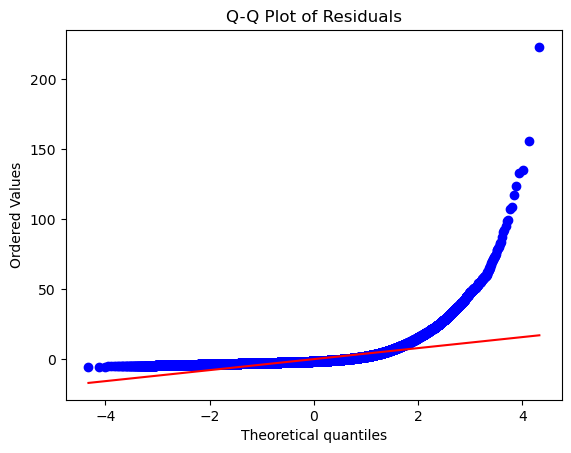

In [ ]:
# Histogram
sns.histplot(residuals, kde=True)
plt.title("Residuals Histogram")
plt.show()

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

- Check actual distribution of LOS

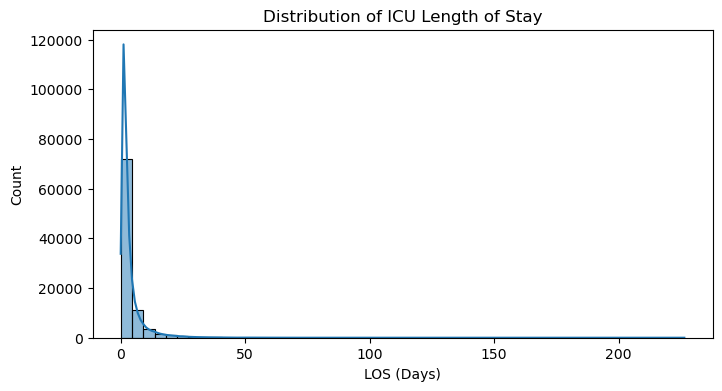

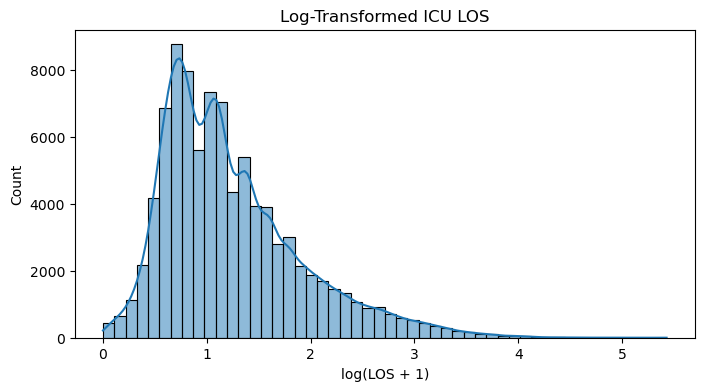

In [ ]:
# Raw LOS
plt.figure(figsize=(8, 4))
sns.histplot(icu_adms['los'], bins=50, kde=True)
plt.title("Distribution of ICU Length of Stay")
plt.xlabel("LOS (Days)")
plt.show()

# Log-transformed
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(icu_adms['los']), bins=50, kde=True)
plt.title("Log-Transformed ICU LOS")
plt.xlabel("log(LOS + 1)")
plt.show()

- Try log transforming LOS to improve regression fit since original LOS is highly skewed

In [ ]:
model_loglos = smf.ols(formula='np.log(los) ~ age + gender + insurance + race + comorbidity_score + first_careunit', data=icu_adms).fit()
model_loglos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(los)   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     108.9
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:56:25   Log-Likelihood:            -1.2537e+05
No. Observations:               90561   AIC:                         2.508e+05
Df Residuals:                   90531   BIC:                         2.511e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              0.6907      0.073      9.517      0.000       0.548       0.833
gender[T.M]                                                            0.0419      0.007      6.401      0.000       0.029       0.055
insurance[T.Medicare]                                                  0.0225      0.010      2.150      0.032       0.002       0.043
insurance[T.Private]                                                  -0.0038      0.010     -0.365      0.715      -0.024       0.017
race[T.ASIAN]                                                         -0.0674      0.073     -0.925      0.355      -0.210       0.075
race[T.BLACK]                                                         -0.0796      0.071     -1.119      0.263      -0.219       0.060
race[T.HISPANIC/LATINO]                                               -0.0791      0.072     -1.092      0.275      -0.221       0.063
race[T.MULTIPLE RACE/ETHNICITY]                                       -0.1256      0.138     -0.913      0.361      -0.395       0.144
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                        -0.0822      0.113     -0.726      0.468      -0.304       0.140
race[T.OTHER]                                                         -0.0313      0.073     -0.430      0.667      -0.174       0.111
race[T.UNKNOWN]                                                        0.1401      0.071      1.969      0.049       0.001       0.280
race[T.WHITE]                                                         -0.0658      0.071     -0.932      0.351      -0.204       0.073
first_careunit[T.Coronary Care Unit (CCU)]                            -0.1047      0.013     -8.314      0.000      -0.129      -0.080
first_careunit[T.Intensive Care Unit (ICU)]                            0.8461      0.177      4.790      0.000       0.500       1.192
first_careunit[T.Med/Surg]                                            -0.3014      0.966     -0.312      0.755      -2.196       1.593
first_careunit[T.Medical Intensive Care Unit (MICU)]                  -0.0528      0.011     -4.830      0.000      -0.074      -0.031
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]    -0.1722      0.012    -14.769      0.000      -0.195      -0.149
first_careunit[T.Medicine]                                             1.7517      0.242      7.247      0.000       1.278       2.225
first_careunit[T.Medicine/Cardiology Intermediate]                    -0.2889      0.966     -0.299      0.765      -2.183       1.605
first_careunit[T.Neuro Intermediate]                                   0.3516      0.015     22.912      0.000   

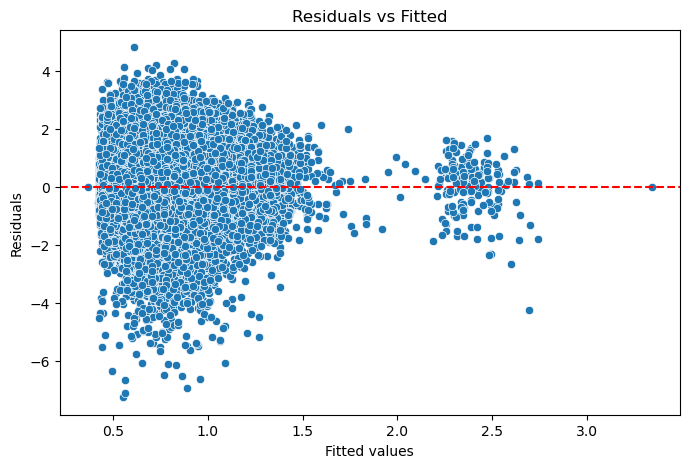

In [ ]:
residuals_log = model_loglos.resid
fitted_log = model_loglos.fittedvalues

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_log, y=residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

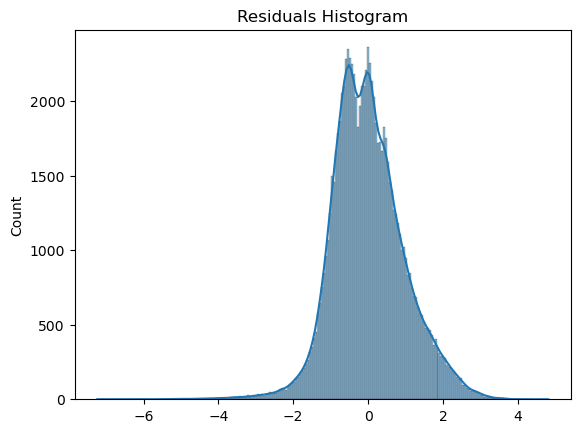

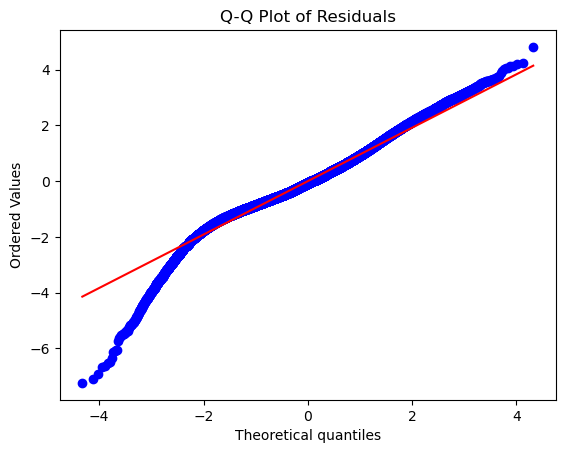

In [ ]:
# Histogram
sns.histplot(residuals_log, kde=True)
plt.title("Residuals Histogram")
plt.show()

# Q-Q Plot
stats.probplot(residuals_log, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

- Distribution of residuals and spread look much better and normal, but still maybe not meeting all assumptions

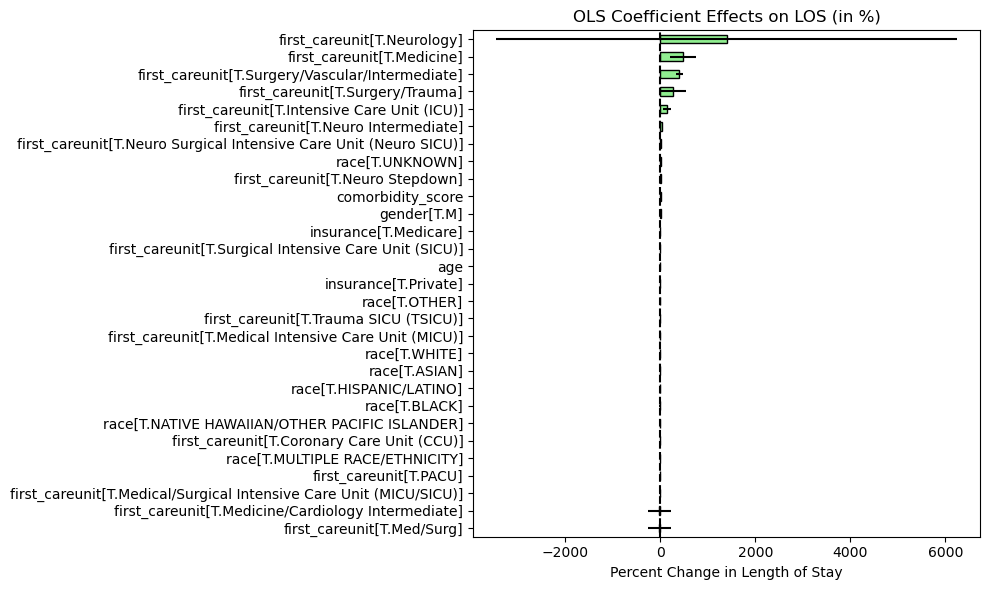

In [ ]:
# Get coefficients (excluding intercept)
coef = model_loglos.params.drop("Intercept")

# Get confidence intervals for the same coefficients
conf_int = model_loglos.conf_int().loc[coef.index]
errors = (conf_int[1] - conf_int[0]) / 2

percent_effect = (np.exp(coef) - 1) * 100
error_bars = ((np.exp(conf_int[1]) - np.exp(conf_int[0])) / 2) * 100

plt.figure(figsize=(10, 6))
percent_effect.sort_values().plot(
    kind="barh",
    xerr=error_bars[percent_effect.sort_values().index],
    color="lightgreen", edgecolor="black"
)
plt.title("OLS Coefficient Effects on LOS (in %)")
plt.xlabel("Percent Change in Length of Stay")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


- Just Medicaid vs. Private insurance

In [ ]:
icu_adms.columns

Index(['subject_id', 'hadm_id', 'race', 'insurance', 'admittime', 'dischtime',
       'deathtime', 'stay_id', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'aids', 'ami', 'canc', 'cevd', 'chf',
       'copd', 'dementia', 'diab', 'diabwc', 'hp', 'metacanc', 'mld', 'msld',
       'pud', 'pvd', 'rend', 'rheumd', 'comorbidity_score', 'age',
       'in_icu_mortality', 'age_group', 'hour', 'weekday', 'month',
       'is_weekend', 'age_scaled', 'comorbidity_scaled'],
      dtype='object')

In [ ]:
# LOS (OLS)
ols_insurance = smf.ols("np.log(los) ~ insurance + age + race + gender + comorbidity_score + first_careunit", data=subset_icu).fit()
ols_insurance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(los)   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     71.58
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:57:36   Log-Likelihood:                -54058.
No. Observations:               38758   AIC:                         1.082e+05
Df Residuals:                   38732   BIC:                         1.084e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              0.4918      0.116      4.225      0.000       0.264       0.720
insurance[T.Medicaid]                                                  0.0032      0.011      0.297      0.767      -0.018       0.024
race[T.ASIAN]                                                         -0.0665      0.116     -0.573      0.567      -0.294       0.161
race[T.BLACK]                                                         -0.0580      0.114     -0.506      0.613      -0.282       0.166
race[T.HISPANIC/LATINO]                                               -0.0744      0.116     -0.643      0.520      -0.301       0.152
race[T.MULTIPLE RACE/ETHNICITY]                                        0.0525      0.197      0.267      0.790      -0.333       0.438
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                        -0.1478      0.175     -0.845      0.398      -0.490       0.195
race[T.OTHER]                                                          0.0066      0.116      0.057      0.955      -0.221       0.235
race[T.UNKNOWN]                                                        0.1956      0.115      1.708      0.088      -0.029       0.420
race[T.WHITE]                                                         -0.0425      0.114     -0.374      0.708      -0.266       0.180
gender[T.M]                                                            0.0389      0.010      3.798      0.000       0.019       0.059
first_careunit[T.Coronary Care Unit (CCU)]                            -0.0876      0.021     -4.131      0.000      -0.129      -0.046
first_careunit[T.Intensive Care Unit (ICU)]                            1.5163      0.369      4.105      0.000       0.792       2.240
first_careunit[T.Medical Intensive Care Unit (MICU)]                   0.0242      0.017      1.398      0.162      -0.010       0.058
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]    -0.1409      0.018     -7.688      0.000      -0.177      -0.105
first_careunit[T.Medicine]                                             2.0594      0.309      6.663      0.000       1.454       2.665
first_careunit[T.Neuro Intermediate]                                   0.3955      0.023     17.362      0.000       0.351       0.440
first_careunit[T.Neuro Stepdown]                                       0.1669      0.039      4.244      0.000       0.090       0.244
first_careunit[T.Neuro Surgical Intensive Care Unit (Neuro SICU)]      0.2456      0.040      6.185      0.000       0.168       0.323
first_careunit[T.PACU]                                                -0.2929      0.146     -2.004      0.045   

**note: baseline race is American Indian/Alaska Native for race coeff comparison**

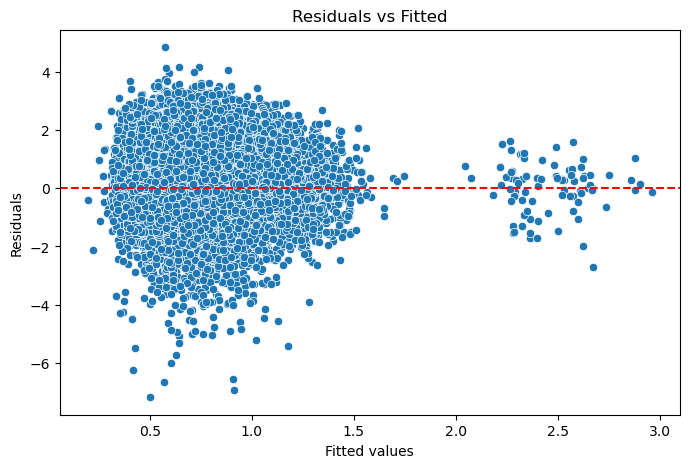

In [ ]:
residuals_log = ols_insurance.resid
fitted_log = ols_insurance.fittedvalues

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_log, y=residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

- didn't really change significance of Medicaid vs. Private

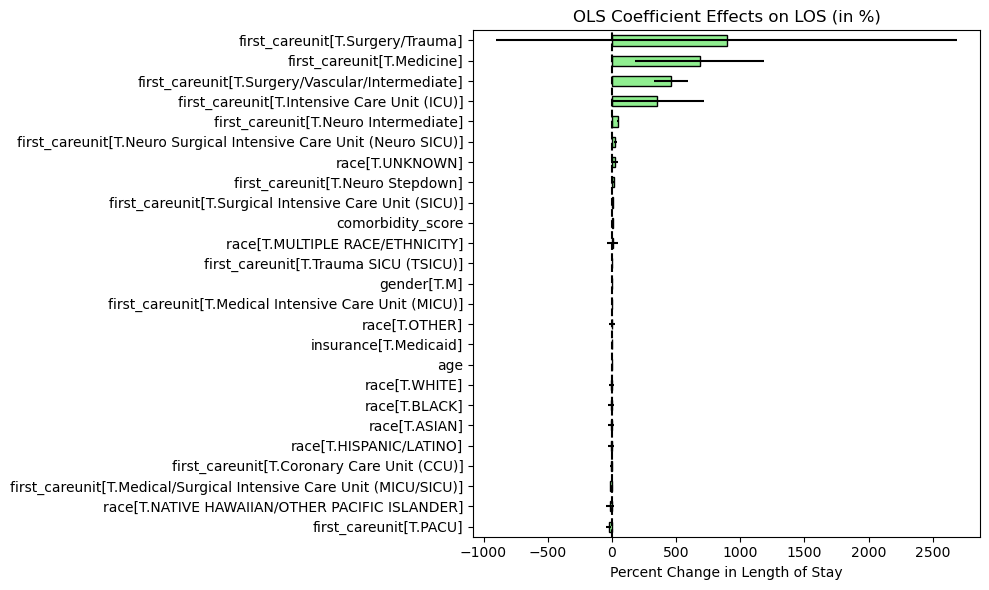

In [ ]:
# Get coefficients (excluding intercept)
coef = ols_insurance.params.drop("Intercept")

# Get confidence intervals for the same coefficients
conf_int = ols_insurance.conf_int().loc[coef.index]
errors = (conf_int[1] - conf_int[0]) / 2

percent_effect = (np.exp(coef) - 1) * 100
error_bars = ((np.exp(conf_int[1]) - np.exp(conf_int[0])) / 2) * 100

plt.figure(figsize=(10, 6))
percent_effect.sort_values().plot(
    kind="barh",
    xerr=error_bars[percent_effect.sort_values().index],
    color="lightgreen", edgecolor="black"
)
plt.title("OLS Coefficient Effects on LOS (in %)")
plt.xlabel("Percent Change in Length of Stay")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

**Without UNKNOWN race**

In [ ]:
# LOS (OLS)
ols_insurancek = smf.ols("np.log(los) ~ insurance + age + race + gender + comorbidity_score + first_careunit", data=known_race).fit()
ols_insurancek.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(los)   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     85.10
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:57:45   Log-Likelihood:            -1.1096e+05
No. Observations:               80632   AIC:                         2.220e+05
Df Residuals:                   80604   BIC:                         2.222e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              0.7012      0.072      9.706      0.000       0.560       0.843
insurance[T.Medicare]                                                  0.0310      0.011      2.821      0.005       0.009       0.053
insurance[T.Private]                                                   0.0013      0.011      0.117      0.907      -0.020       0.023
race[T.ASIAN]                                                         -0.0670      0.072     -0.927      0.354      -0.209       0.075
race[T.BLACK]                                                         -0.0768      0.071     -1.089      0.276      -0.215       0.061
race[T.HISPANIC/LATINO]                                               -0.0774      0.072     -1.077      0.282      -0.218       0.063
race[T.MULTIPLE RACE/ETHNICITY]                                       -0.1291      0.136     -0.946      0.344      -0.396       0.138
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                        -0.0836      0.112     -0.745      0.457      -0.304       0.137
race[T.OTHER]                                                         -0.0328      0.072     -0.455      0.649      -0.174       0.109
race[T.WHITE]                                                         -0.0691      0.070     -0.986      0.324      -0.206       0.068
gender[T.M]                                                            0.0477      0.007      6.940      0.000       0.034       0.061
first_careunit[T.Coronary Care Unit (CCU)]                            -0.1120      0.013     -8.380      0.000      -0.138      -0.086
first_careunit[T.Intensive Care Unit (ICU)]                            0.9114      0.196      4.654      0.000       0.528       1.295
first_careunit[T.Med/Surg]                                            -0.3284      0.958     -0.343      0.732      -2.207       1.550
first_careunit[T.Medical Intensive Care Unit (MICU)]                  -0.0864      0.012     -7.497      0.000      -0.109      -0.064
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]    -0.1888      0.012    -15.471      0.000      -0.213      -0.165
first_careunit[T.Medicine]                                             1.6980      0.289      5.874      0.000       1.131       2.265
first_careunit[T.Neuro Intermediate]                                   0.3058      0.016     18.718      0.000       0.274       0.338
first_careunit[T.Neuro Stepdown]                                       0.0863      0.029      2.986      0.003       0.030       0.143
first_careunit[T.Neuro Surgical Intensive Care Unit (Neuro SICU)]      0.1099      0.029      3.812      0.000   

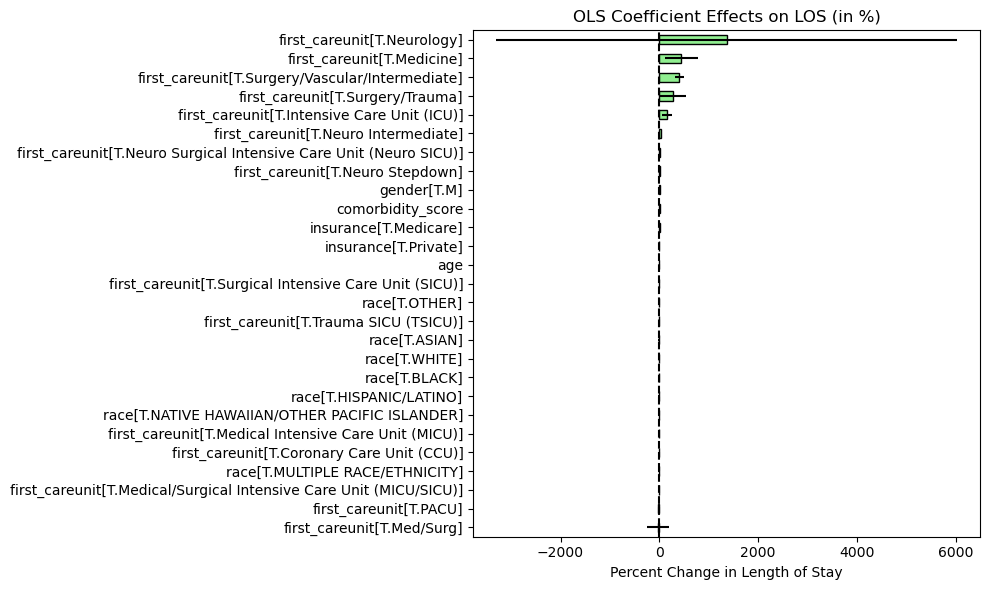

In [ ]:
# Get coefficients (excluding intercept)
coef = ols_insurancek.params.drop("Intercept")

# Get confidence intervals for the same coefficients
conf_int = ols_insurancek.conf_int().loc[coef.index]
errors = (conf_int[1] - conf_int[0]) / 2

percent_effect = (np.exp(coef) - 1) * 100
error_bars = ((np.exp(conf_int[1]) - np.exp(conf_int[0])) / 2) * 100

plt.figure(figsize=(10, 6))
percent_effect.sort_values().plot(
    kind="barh",
    xerr=error_bars[percent_effect.sort_values().index],
    color="lightgreen", edgecolor="black"
)
plt.title("OLS Coefficient Effects on LOS (in %)")
plt.xlabel("Percent Change in Length of Stay")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

**Trying GLM because homoscedasticity still maybe violated in the log transform**

In [ ]:


model_gamma = smf.glm(formula='los ~ age + gender + insurance + race + comorbidity_score + first_careunit',
                      data=icu_adms,
                      family=sm.families.Gamma(link=sm.families.links.log())).fit()
model_gamma.summary()

c:\Users\atrey\miniconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning:

The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    los   No. Observations:                90561
Model:                            GLM   Df Residuals:                    90531
Model Family:                   Gamma   Df Model:                           29
Link Function:                    log   Scale:                          2.1363
Method:                          IRLS   Log-Likelihood:            -2.2297e+05
Date:                Sun, 23 Nov 2025   Deviance:                       91879.
Time:                        21:57:56   Pearson chi2:                 1.93e+05
No. Iterations:                    16   Pseudo R-squ. (CS):            0.02034
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              1.3009      0.110     11.849      0.000       1.086       1.516
gender[T.M]                                                            0.0608      0.010      6.145      0.000       0.041       0.080
insurance[T.Medicare]                                                 -0.0017      0.016     -0.107      0.915      -0.033       0.029
insurance[T.Private]                                                  -0.0194      0.016     -1.232      0.218      -0.050       0.011
race[T.ASIAN]                                                         -0.1536      0.110     -1.394      0.163      -0.370       0.062
race[T.BLACK]                                                         -0.1639      0.108     -1.522      0.128      -0.375       0.047
race[T.HISPANIC/LATINO]                                               -0.1847      0.110     -1.686      0.092      -0.400       0.030
race[T.MULTIPLE RACE/ETHNICITY]                                       -0.4306      0.208     -2.070      0.038      -0.838      -0.023
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                        -0.1799      0.171     -1.050      0.294      -0.516       0.156
race[T.OTHER]                                                         -0.1099      0.110     -0.999      0.318      -0.325       0.106
race[T.UNKNOWN]                                                        0.0851      0.108      0.790      0.429      -0.126       0.296
race[T.WHITE]                                                         -0.1704      0.107     -1.595      0.111      -0.380       0.039
first_careunit[T.Coronary Care Unit (CCU)]                            -0.1218      0.019     -6.391      0.000      -0.159      -0.084
first_careunit[T.Intensive Care Unit (ICU)]                            1.0162      0.267      3.803      0.000       0.492       1.540
first_careunit[T.Med/Surg]                                            -0.6820      1.462     -0.467      0.641      -3.547       2.183
first_careunit[T.Medical Intensive Care Unit (MICU)]                   0.0792      0.017      4.790      0.000       0.047       0.112
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]    -0.1090      0.018     -6.184      0.000      -0.144      -0.074
first_careunit[T.Medicine]                                             1.5397      0.366      4.211      0.000       0.823       2.256
first_careunit[T.Medicine/Cardiology Intermediate]                    -0.7621      1.462     -0.521      0.602      -3.627       2.103
first_careunit[T.Neuro Intermediate]                                   0.4082      0.023     17.580      0.000   

In [ ]:
model_gamma.pvalues

Intercept                                                              2.166580e-32
gender[T.M]                                                            7.982196e-10
insurance[T.Medicare]                                                  9.147246e-01
insurance[T.Private]                                                   2.178614e-01
race[T.ASIAN]                                                          1.632201e-01
race[T.BLACK]                                                          1.278984e-01
race[T.HISPANIC/LATINO]                                                9.181470e-02
race[T.MULTIPLE RACE/ETHNICITY]                                        3.845621e-02
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         2.936408e-01
race[T.OTHER]                                                          3.176839e-01
race[T.UNKNOWN]                                                        4.292380e-01
race[T.WHITE]                                                          1.106

**without UNKNOWN race**

In [ ]:
model_gamma2 = smf.glm(formula='los ~ age + gender + insurance + race + comorbidity_score + first_careunit',
                      data=known_race,
                      family=sm.families.Gamma(link=sm.families.links.log())).fit()
model_gamma2.summary()

c:\Users\atrey\miniconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning:

The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    los   No. Observations:                80632
Model:                            GLM   Df Residuals:                    80604
Model Family:                   Gamma   Df Model:                           27
Link Function:                    log   Scale:                          2.1731
Method:                          IRLS   Log-Likelihood:            -1.9711e+05
Date:                Sun, 23 Nov 2025   Deviance:                       81102.
Time:                        21:58:05   Pearson chi2:                 1.75e+05
No. Iterations:                    16   Pseudo R-squ. (CS):            0.01556
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              1.3042      0.111     11.735      0.000       1.086       1.522
gender[T.M]                                                            0.0707      0.011      6.689      0.000       0.050       0.091
insurance[T.Medicare]                                                  0.0092      0.017      0.541      0.589      -0.024       0.042
insurance[T.Private]                                                  -0.0102      0.017     -0.598      0.550      -0.043       0.023
race[T.ASIAN]                                                         -0.1527      0.111     -1.374      0.169      -0.371       0.065
race[T.BLACK]                                                         -0.1599      0.109     -1.473      0.141      -0.373       0.053
race[T.HISPANIC/LATINO]                                               -0.1829      0.111     -1.655      0.098      -0.400       0.034
race[T.MULTIPLE RACE/ETHNICITY]                                       -0.4337      0.210     -2.067      0.039      -0.845      -0.023
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                        -0.1841      0.173     -1.065      0.287      -0.523       0.155
race[T.OTHER]                                                         -0.1108      0.111     -0.999      0.318      -0.328       0.107
race[T.WHITE]                                                         -0.1731      0.108     -1.607      0.108      -0.384       0.038
first_careunit[T.Coronary Care Unit (CCU)]                            -0.1270      0.021     -6.180      0.000      -0.167      -0.087
first_careunit[T.Intensive Care Unit (ICU)]                            1.0206      0.301      3.388      0.001       0.430       1.611
first_careunit[T.Med/Surg]                                            -0.7048      1.474     -0.478      0.633      -3.595       2.185
first_careunit[T.Medical Intensive Care Unit (MICU)]                   0.0453      0.018      2.556      0.011       0.011       0.080
first_careunit[T.Medical/Surgical Intensive Care Unit (MICU/SICU)]    -0.1236      0.019     -6.581      0.000      -0.160      -0.087
first_careunit[T.Medicine]                                             1.4311      0.445      3.218      0.001       0.560       2.303
first_careunit[T.Neuro Intermediate]                                   0.3709      0.025     14.758      0.000       0.322       0.420
first_careunit[T.Neuro Stepdown]                                       0.1680      0.044      3.780      0.000       0.081       0.255
first_careunit[T.Neuro Surgical Intensive Care Unit (Neuro SICU)]      0.2536      0.044      5.717      0.000   

In [ ]:
model_gamma2.pvalues

Intercept                                                              8.405469e-32
gender[T.M]                                                            2.253209e-11
insurance[T.Medicare]                                                  5.888128e-01
insurance[T.Private]                                                   5.495987e-01
race[T.ASIAN]                                                          1.693814e-01
race[T.BLACK]                                                          1.407705e-01
race[T.HISPANIC/LATINO]                                                9.795122e-02
race[T.MULTIPLE RACE/ETHNICITY]                                        3.871273e-02
race[T.NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER]                         2.867303e-01
race[T.OTHER]                                                          3.180130e-01
race[T.WHITE]                                                          1.079774e-01
first_careunit[T.Coronary Care Unit (CCU)]                             6.428

c:\Users\atrey\miniconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:521: RuntimeWarning:

invalid value encountered in sqrt



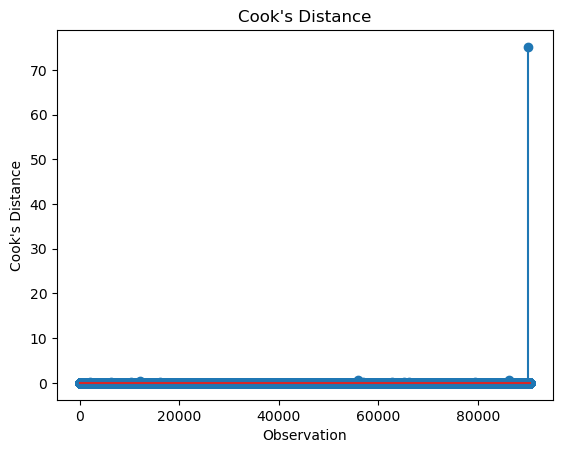

In [ ]:
infl = model_gamma.get_influence()
cooks = infl.cooks_distance[0]
plt.stem(cooks)
plt.title("Cook's Distance")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.show()
#check cook's distance for influential points

In [ ]:
print("Residual deviance:", model_gamma.deviance)
print("Degrees of freedom:", model_gamma.df_resid)
print("Ratio (should be close to 1 if good):", model_gamma.deviance/model_gamma.df_resid)



Residual deviance: 91878.66970499264
Degrees of freedom: 90531
Ratio (should be close to 1 if good): 1.0148862787884


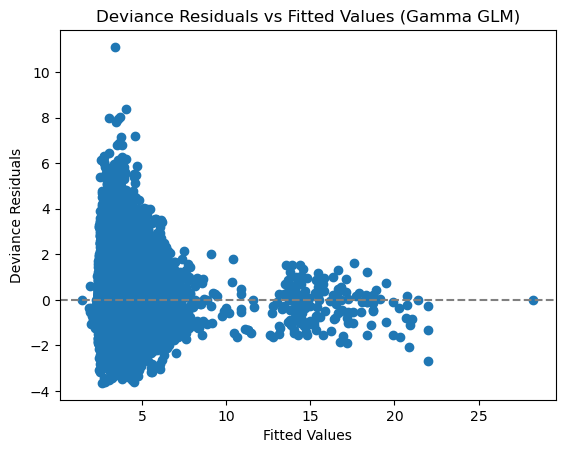

In [ ]:
plt.scatter(model_gamma.fittedvalues, model_gamma.resid_deviance)
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Deviance Residuals vs Fitted Values (Gamma GLM)")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


Spread doesn't look that great, but GLM doesn't really need to satisfy linearity.

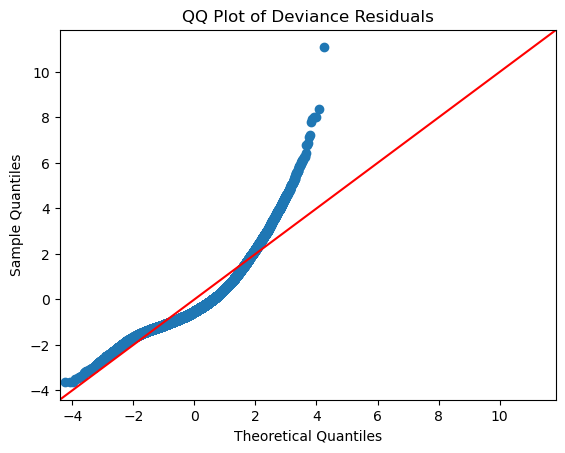

In [ ]:
sm.qqplot(model_gamma.resid_deviance, line='45')
plt.title("QQ Plot of Deviance Residuals")
plt.show()


### ML Model to Rank Feature Importance
Run XGBoost to see which features most strongly predict mortality or LOS

- Plot gain-based importance by race, gender, insurance, age  
- get SHAP values

In [ ]:
#turn into categories in case
icu_adms["insurance"] = icu_adms["insurance"].astype("category")
icu_adms["race"] = icu_adms["race"].astype("category")
icu_adms["gender"] = icu_adms["gender"].astype("category")
icu_adms["age_group"] = icu_adms["age_group"].astype("category")
icu_adms["is_weekend"] = icu_adms["is_weekend"].astype("category")

In [ ]:
icu_adms['in_icu_mortality'].value_counts(normalize=True) #class imbalance


in_icu_mortality
0    0.919723
1    0.080277
Name: proportion, dtype: float64

In [ ]:
# Prepare features
X = icu_adms[["age_group", "gender", "insurance", "race", "is_weekend", "comorbidity_score"]].copy()
X = pd.get_dummies(X, drop_first=True) #dummy variables encoded for model

y = icu_adms["in_icu_mortality"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() #try to treat class imbalance since 92% of data is 0 for in icu mortality


In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

c:\Users\atrey\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:58:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Get Gain to understand feature importance:  

a metric used to evaluate the importance of a feature by measuring the improvement in accuracy (or reduction in loss) a feature provides when it's used to split nodes in decision trees. It essentially quantifies how much a feature contributes to reducing prediction errors across the entire ensemble of trees

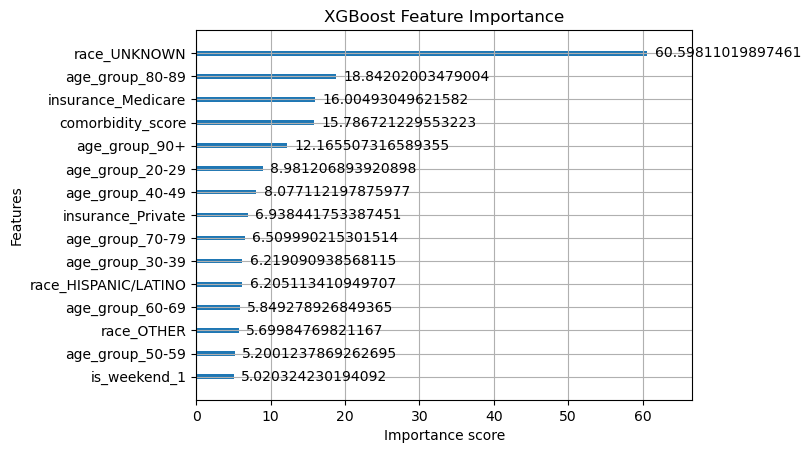

In [ ]:
xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.show()

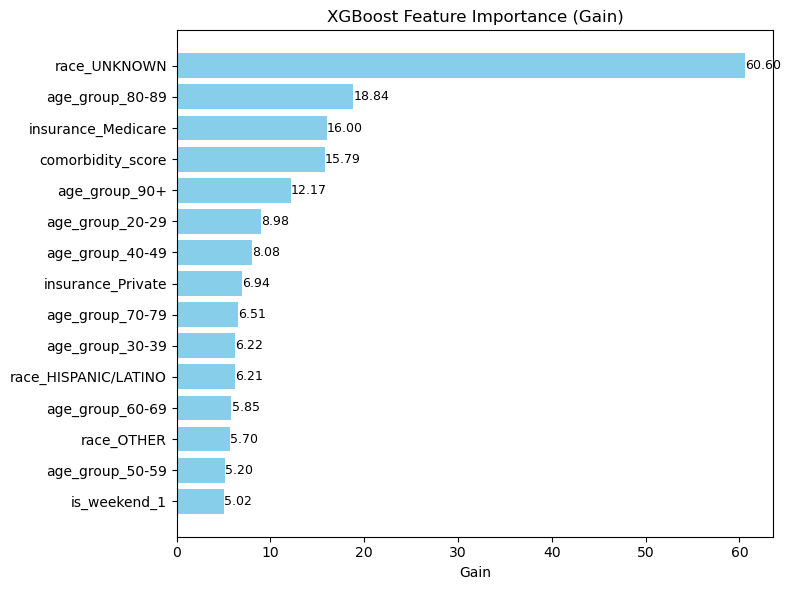

In [ ]:
# plot better for presentation (help from ChatGPT)
# Get the raw feature importance (gain)
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
})

# Sort and round
importance_df = importance_df.sort_values(by='Gain', ascending=False).head(15)
importance_df['Gain'] = importance_df['Gain'].round(2)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.title('XGBoost Feature Importance (Gain)')
plt.gca().invert_yaxis()

# Annotate each bar with the gain value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
# get eval
y_pred = model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred))

AUC: 0.6599054567868355


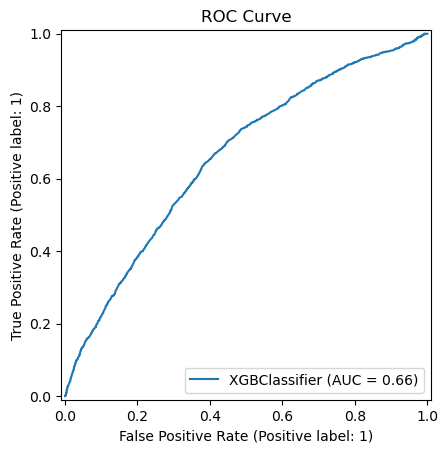

In [ ]:
from sklearn.metrics import RocCurveDisplay
#roc curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

What “Gain” means:
How much each feature contributed (on average) to improving the model when it was used to split a decision tree.

--- relative to the values inside. RACE UNKNOWN is big so if race unknown is seen it is a huge predictor of mortality. try without that

In [ ]:
X_race = X.drop(columns=['race_UNKNOWN'])
X_race = X_race.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_race, y, test_size=0.2, random_state=42)

model_slim = XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)
model_slim.fit(X_train, y_train)

c:\Users\atrey\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:59:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

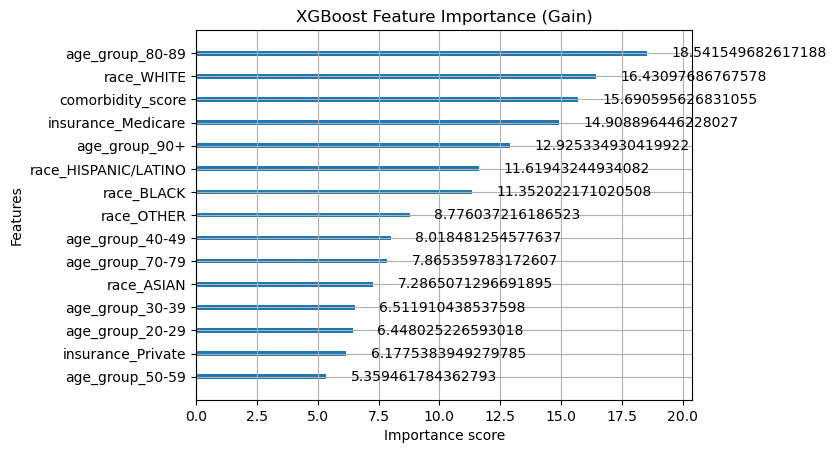

In [ ]:
xgb.plot_importance(model_slim, importance_type='gain', max_num_features=15)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

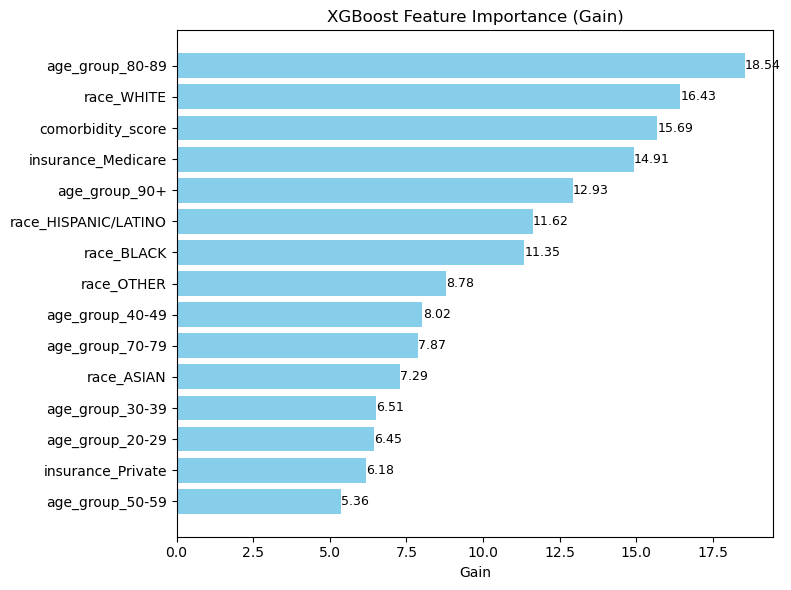

In [ ]:
# better graph for presentation
# Get the raw feature importance (gain)
booster = model_slim.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
})

# Sort and round
importance_df = importance_df.sort_values(by='Gain', ascending=False).head(15)
importance_df['Gain'] = importance_df['Gain'].round(2)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.title('XGBoost Feature Importance (Gain)')
plt.gca().invert_yaxis()

# Annotate each bar with the gain value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


In [ ]:

y_pred = model_slim.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred))

AUC: 0.6612049786543203


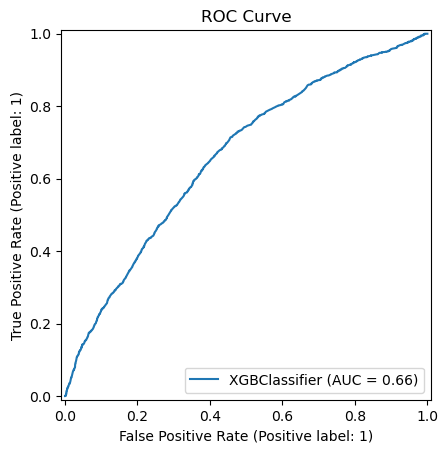

In [ ]:
#roc curve
RocCurveDisplay.from_estimator(model_slim, X_test, y_test)
plt.title("ROC Curve")
plt.show()


**ROC-AUC not that great, might have to consider other features or some tuning?**

Get SHAP values:  
To tell how much each feature contributes to the difference between the model's prediction for a specific instance and the average prediction for the entire dataset. Can be used to understand feature importance by analyzing the magnitude of the values. Larger absolute SHAP values indicate a greater impact on the prediction.

In [ ]:
X_train = X_train.astype(int)

100%|===================| 72413/72448 [07:33<00:00]        

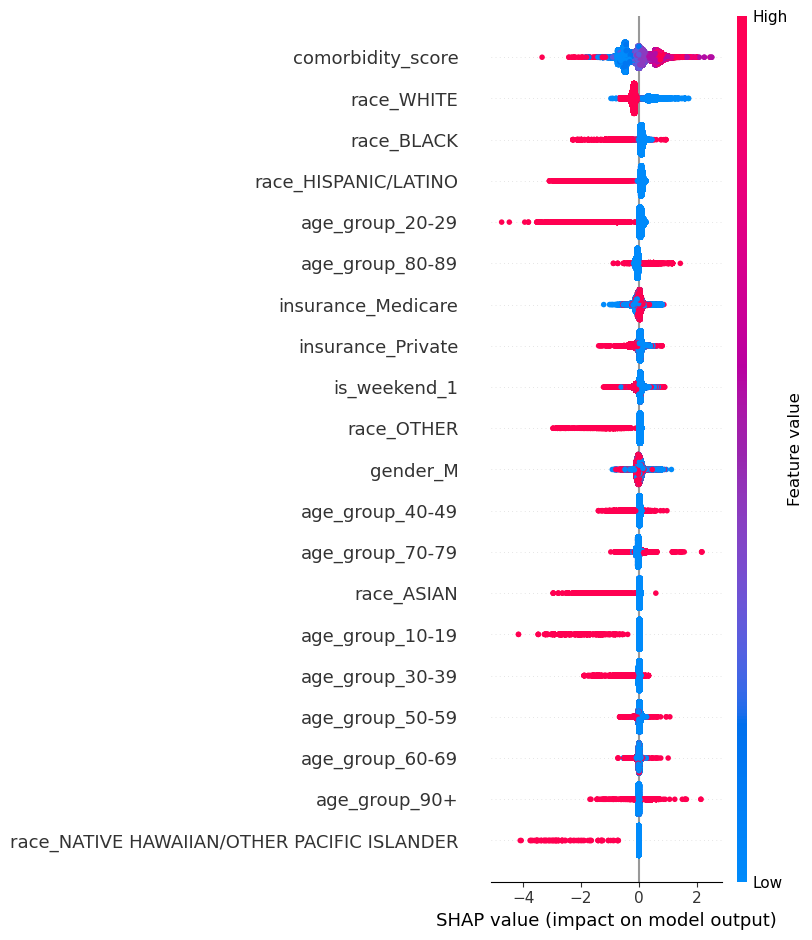

In [ ]:

explainer = shap.Explainer(model_slim, X_train)
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

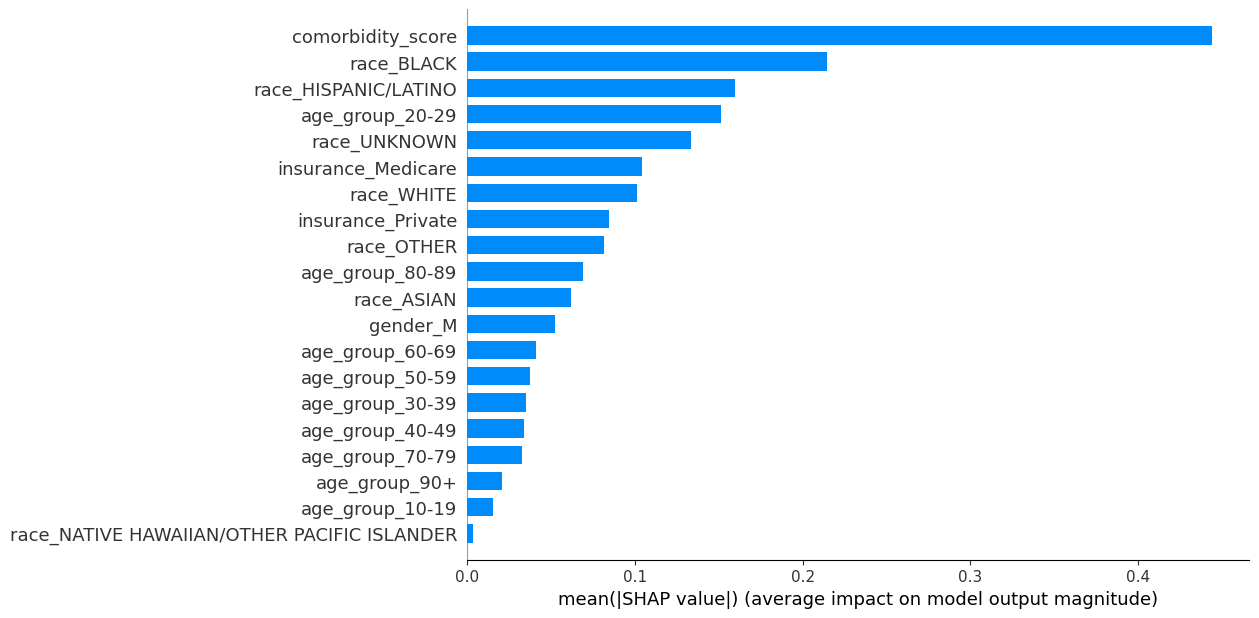

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
fig = plt.gcf()
fig.set_size_inches(20, 6) # Set desired width and height in inches

# Display the resized plot
plt.show()

In [ ]:
#Get logit coefficients to compare to shap
logit_coefs = mortality_model.params.drop('Intercept')

# Rename logit feature names to match SHAP names
logit_renamed = logit_coefs.copy()
logit_renamed.index = (
    logit_renamed.index
    .str.replace("T.", "", regex=False)
    .str.replace("]", "")  # remove "T." from dummy variable names
    .str.replace("[", "_", regex=False)  # change [ to underscore if any

)

#Reindex logit coefs to match SHAP index
logit_aligned = logit_renamed.reindex(X_test.columns)

# Build SHAP summary
shap_importance = pd.DataFrame({
    "Mean |SHAP|": np.abs(shap_values.values).mean(axis=0),
}, index=X_test.columns)

# Combine into comparison dataframe
comparison_df = pd.concat([logit_aligned, shap_importance], axis=1)
comparison_df.columns = ["Logit Coef", "Mean |SHAP|"]
comparison_df = comparison_df.sort_values("Mean |SHAP|", ascending=False)

display(comparison_df)



Logit Coef  Mean |SHAP|
comorbidity_score                              0.183628     0.428768
race_WHITE                                    -0.252320     0.281450
race_BLACK                                    -0.237348     0.157061
race_HISPANIC/LATINO                          -0.279679     0.139480
age_group_20-29                                     NaN     0.123529
age_group_80-89                                     NaN     0.095975
insurance_Medicare                             0.062616     0.091464
insurance_Private                             -0.110686     0.089836
is_weekend_1                                        NaN     0.086496
race_OTHER                                    -0.227955     0.072307
gender_M                                      -0.015934     0.063795
age_group_40-49                                     NaN     0.059254
age_group_70-79                                     NaN     0.059120
race_ASIAN                                    -0.066681     0.053981
age_group_10-19                                     NaN     0.045020
age_group_30-39                                     NaN     0.040962
age_group_50-59                                     NaN     0.037810
age_group_60-69                                     NaN     0.025201
age_group_90+                                       NaN     0.016194
race_NATIVE HAWAIIAN/OTHER PACIFIC ISLANDER    0.399414     0.003371
race_MULTIPLE RACE/ETHNICITY                   0.044186     0.002597

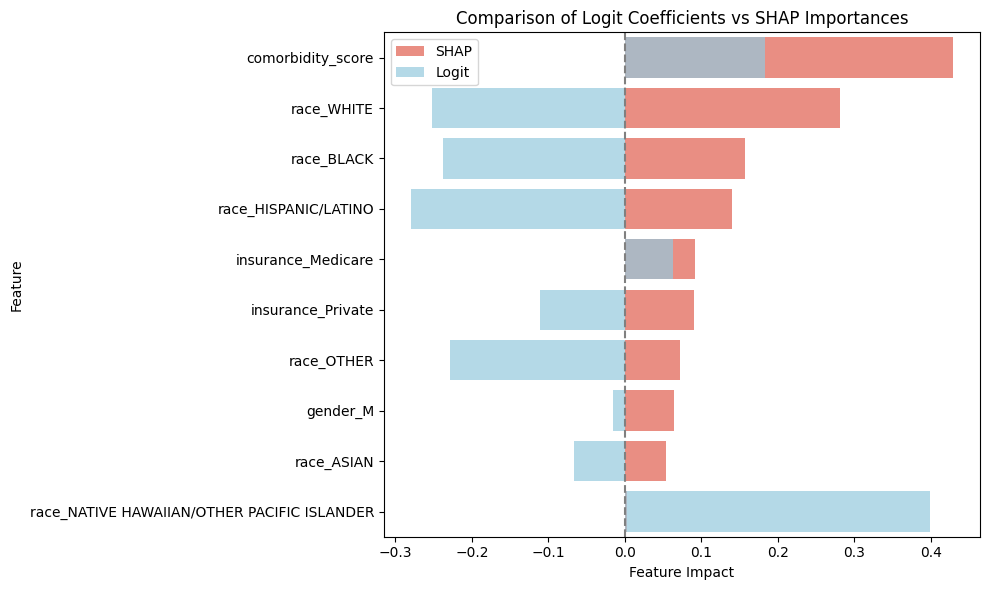

In [ ]:

# Filter top 10 features
top_features = comparison_df.dropna().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features.reset_index(), x="Mean |SHAP|", y="index", color="salmon", label="SHAP")
sns.barplot(data=top_features.reset_index(), x="Logit Coef", y="index", color="skyblue", label="Logit", alpha=0.7)
plt.axvline(0, color='grey', linestyle='--')
plt.legend()
plt.xlabel("Feature Impact")
plt.ylabel("Feature")
plt.title("Comparison of Logit Coefficients vs SHAP Importances")
plt.tight_layout()
plt.show()


## XGB Regressor for Length of Stay

In [ ]:
#LOS setting up variables
X2 = icu_adms.drop(columns=['los'])
X2 = icu_adms[["age", "gender", "insurance", "race", "age_group", "comorbidity_score"]].copy()
X2 = pd.get_dummies(X2, drop_first=True)
y2 = np.log(icu_adms['los'])


X2_race = X2.drop(columns=['race_UNKNOWN'])


X2_train, X2_test, y2_train, y2_test = train_test_split(X2_race, y2, test_size=0.2, random_state=42)



*might try tuning model parameters with a search method if there's time*

In [ ]:
# some parameters from online
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,

)

model_xgb.fit(X2_train, y2_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Back-transform predictions and actuals
y_pred_log = model_xgb.predict(X2_test)  # still in log scale

y_pred_actual = np.exp(y_pred_log)
y_test_actual = np.exp(y2_test)

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

rmse = root_mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"RMSE: {rmse:.2f} days")
print(f"MAE: {mae:.2f} days")
print(f"R² Score: {r2:.3f}")


RMSE: 5.50 days
MAE: 2.49 days
R² Score: -0.066


- Looking at feature importance to see what features contribute to the model

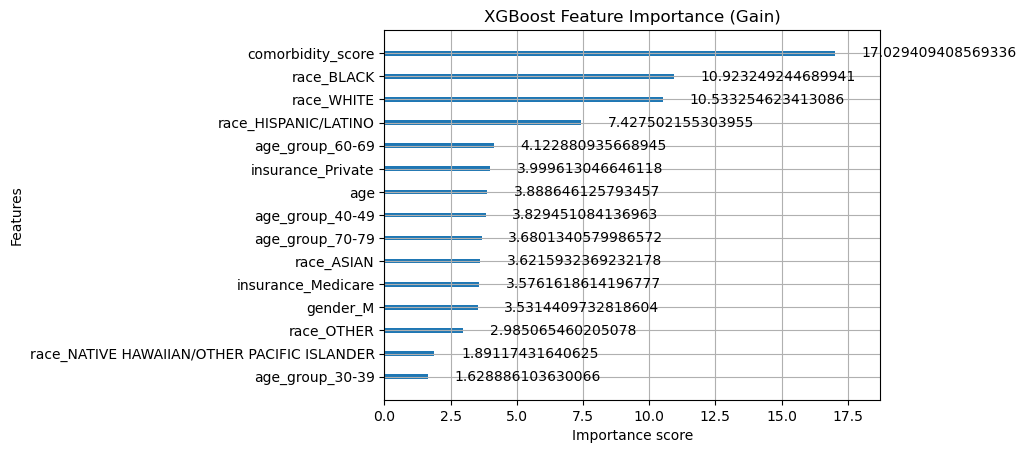

In [ ]:
xgb.plot_importance(model_xgb, importance_type='gain', max_num_features=15)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

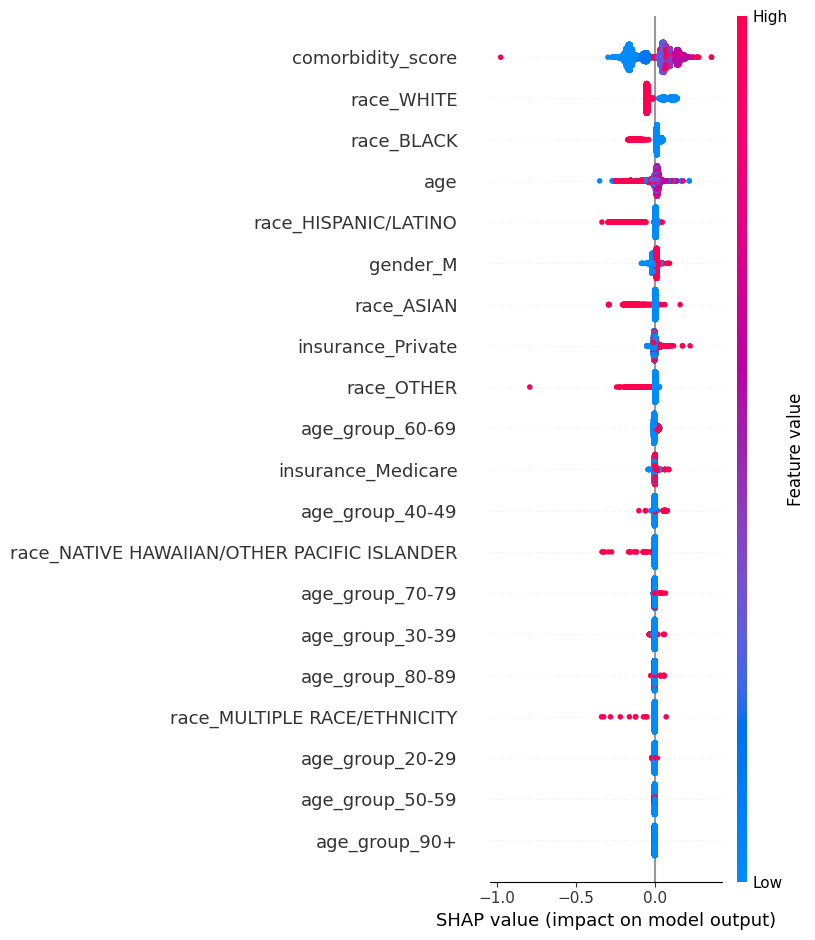

In [ ]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X2_test)

# Summary plot
shap.summary_plot(shap_values, X2_test)


### ICE Plots

In [ ]:
def ice_plot(model, X, feature, num_points=50, sample_size=100):
    """
    model: fitted model with .predict()
    X: pandas DataFrame
    feature: string name of the feature to vary
    num_points: number of values to evaluate along feature range
    sample_size: number of samples to compute ICE curves for
    """

    # 1. pick random subset of rows for ICE
    X_sample = X.sample(sample_size, random_state=0)

    # 2. feature range
    f_min, f_max = X[feature].min(), X[feature].max()
    grid = np.linspace(f_min, f_max, num_points)

    # 3. store ICE curves
    ice_curves = []

    for _, row in X_sample.iterrows():
        row_repeated = pd.DataFrame([row.values] * num_points, columns=X.columns)

        # vary the feature across the grid
        row_repeated[feature] = grid

        # predict
        preds = model.predict(row_repeated.values)
        ice_curves.append(preds)

    ice_curves = np.array(ice_curves)

    # 4. plot ICE
    plt.figure(figsize=(8, 6))
    for i in range(sample_size):
        plt.plot(grid, ice_curves[i], color='gray', alpha=0.3)

    # 5. plot average ICE (cICE)
    plt.plot(grid, ice_curves.mean(axis=0), color='red', linewidth=2, label="cICE (mean)")

    plt.xlabel(feature)
    plt.ylabel("Predicted outcome")
    plt.title(f"ICE Plot for {feature}")
    plt.legend()
    plt.show()

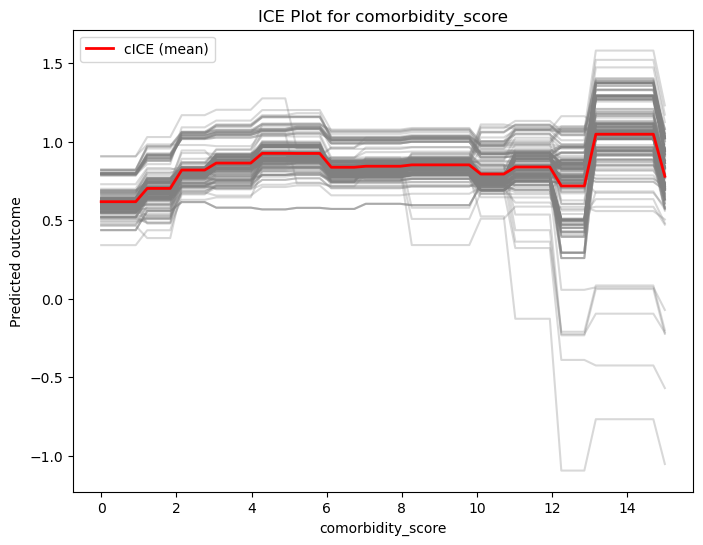

In [ ]:
ice_plot(model_xgb, X2_train, feature="comorbidity_score", num_points=50, sample_size=200)

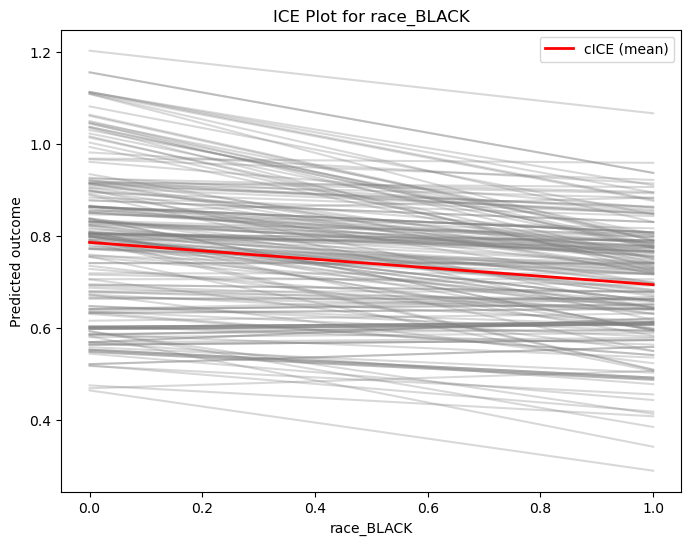

In [ ]:
ice_plot(model_xgb, X2_train, feature="race_BLACK", num_points=2, sample_size=200)

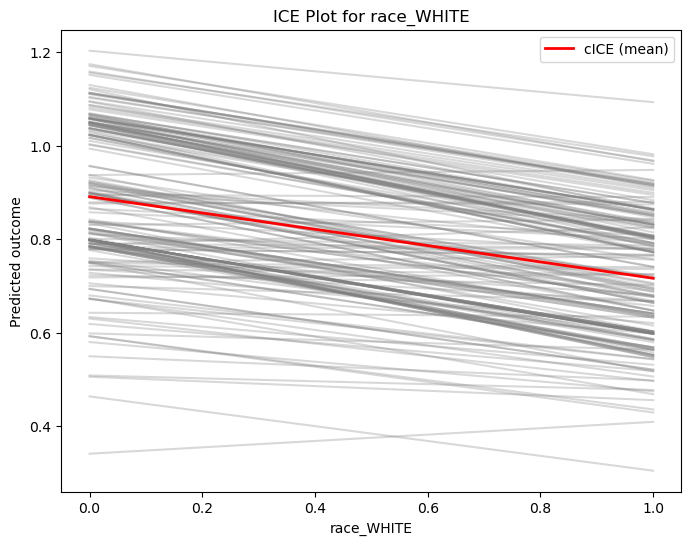

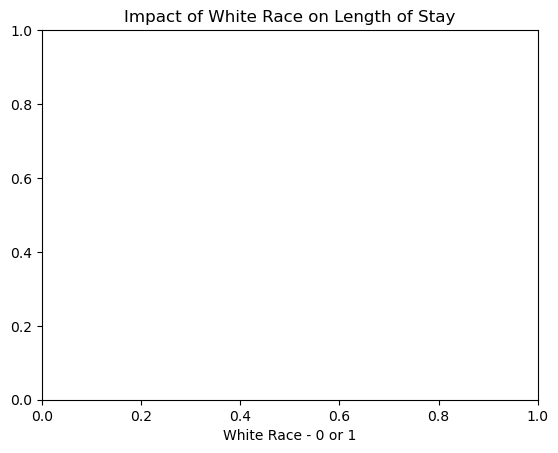

In [ ]:
ice_plot(model_xgb, X2_train, feature="race_WHITE", num_points=2, sample_size=200)
plt.title("Impact of White Race on Length of Stay")
plt.xlabel("White Race - 0 or 1")
plt.show()

### Length of Stay - Insurance Type - ICE Plots

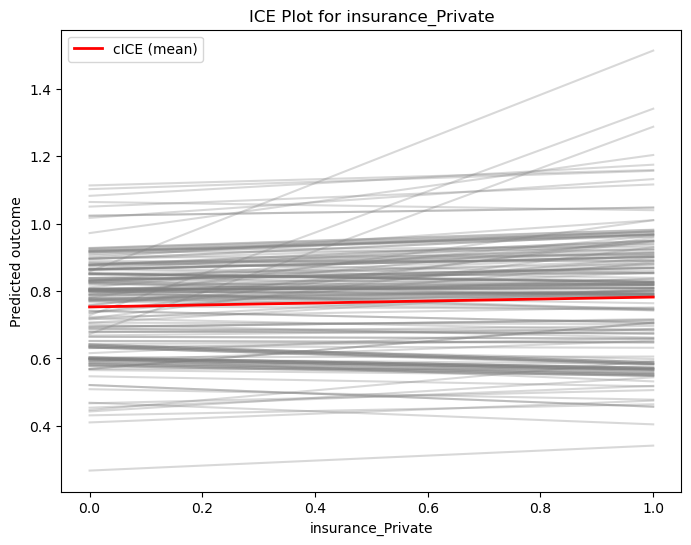

In [ ]:
##
ice_plot(model_xgb, X2_train, feature="insurance_Private", num_points=2, sample_size=200)


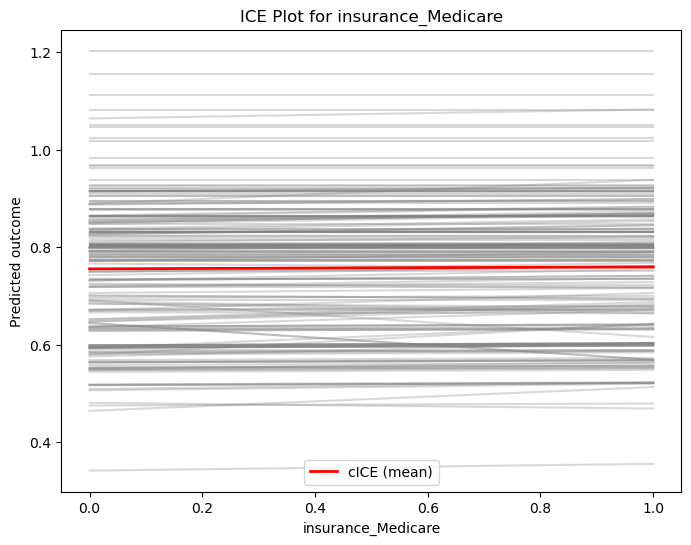

In [ ]:
ice_plot(model_xgb, X2_train, feature="insurance_Medicare", num_points=2, sample_size=200)

In [ ]:
ice_plot(model_xgb, X2_train, feature="insurance_Medicaid", num_points=2, sample_size=200)

KeyError: 'insurance_Medicaid'

## Back to XGB to predict Mortality - ICE Plots

Next steps: Might try pulling in ICD codes and doing a multinomial logit?

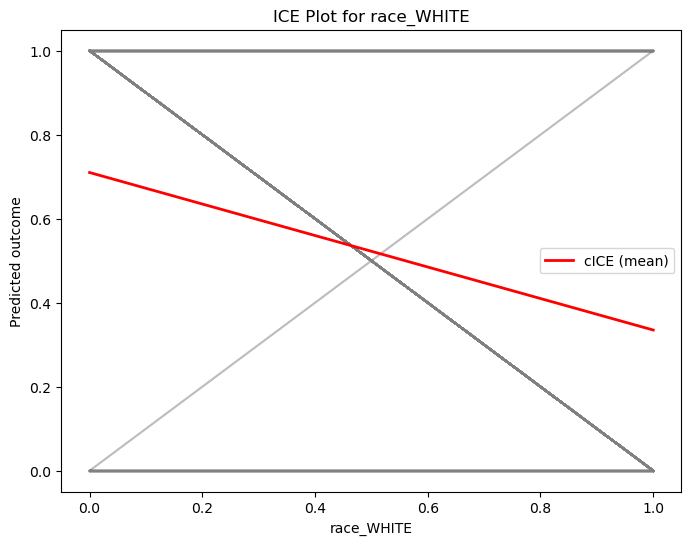

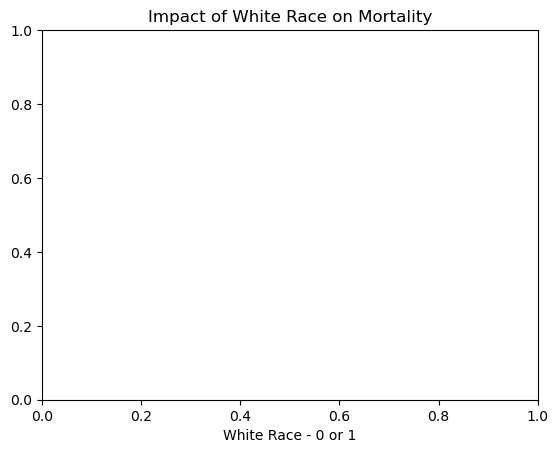

In [ ]:
ice_plot(model_slim, X_train, feature="race_WHITE", num_points=2, sample_size=200)
plt.title("Impact of White Race on Mortality")
plt.xlabel("White Race - 0 or 1")
plt.show()

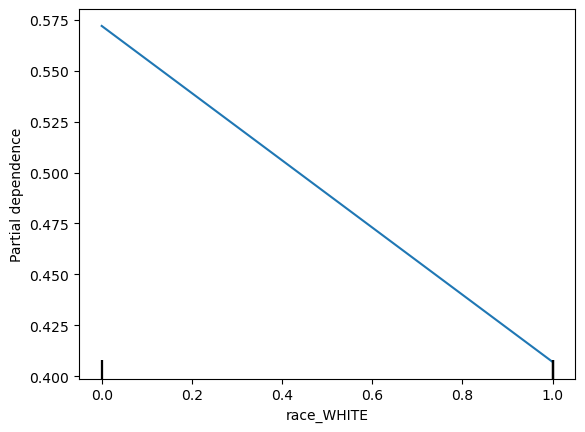

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model_slim, X_train, ["race_WHITE"]
)